In [1]:
# imports
import os
import math
import dill
from itertools import permutations, combinations

import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression as linreg

import suite2p as s2p

import TwoPUtils
import STX3KO_analyses as stx



%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
basedir_VR = '/home/mplitt/VR_scratch'
figdir_local = '/home/mplitt/Fig_scratch'
figdir_remote = '/STX3_2P_results/scratch'

In [10]:

def antic_consum_licks(_sess):
    
    reward_mask = sess.vr_data['reward']._values>0
    reward_start = np.argwhere(reward_mask).ravel()+1
    reward_end = (reward_start + int(2*sess.scan_info['frame_rate'])).astype(np.int)

    consum_mask = np.zeros(reward_mask.shape)>0
    for (start,end) in zip(reward_start,reward_end):
        consum_mask[start:end]=True

    antic_licks = np.copy(sess.vr_data['lick']._values)
    antic_licks[consum_mask]=0
    
    sess.add_timeseries(antic_licks=antic_licks, licks = sess.vr_data['lick']._values, speed = sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix(('antic_licks','speed'),'t',mat_only=True)
    
    
    
    antic_lick_positions = np.zeros(sess.timeseries['licks'].shape)*np.nan
    antic_lick_mask = sess.timeseries['antic_licks']>0
    antic_lick_positions[antic_lick_mask] = sess.vr_data['t']._values[antic_lick_mask.ravel()]
    sess.add_timeseries(antic_lick_positions=antic_lick_positions)
    
def get_probes_and_omissions(sess_):
    
    probes = np.zeros([sess.trial_start_inds.shape[0],])
    omissions = np.zeros([sess.trial_start_inds.shape[0],])
    for trial, (start,stop, lr) in enumerate(zip(sess.trial_start_inds,sess.teleport_inds, sess.trial_info['LR'])):
        if sess.scene in ("YMaze_RewardReversal"):
            lr = np.copy(lr)*-1
        
        pos = sess.vr_data['t'].iloc[start:stop]
        licks = sess.vr_data['lick'].iloc[start:stop]
        reward = sess.vr_data['reward'].iloc[start:stop]
        if lr == 1:
            rzone = (sess.rzone_late['tfront'], sess.rzone_late['tback'])
        else:
            rzone = (sess.rzone_early['tfront'], sess.rzone_early['tback'])
        rzone_mask = (pos>=rzone[0]) & (pos<=rzone[1])
        
        r = reward.sum()
        rzone_licks = licks.loc[rzone_mask].sum()
        if r==0 and rzone_licks>0:
            probes[trial]=1
        elif r==0 and rzone_licks==0:
            omissions[trial]=1
        else:
            pass
        
        sess.trial_info.update({'probes': probes, 'omissions': omissions})
    

def single_trial_lick_metrics(sess):
    
    bin_lower_edges = sess.trial_matrices['bin_edges'][:-1]
    
    lr_early = np.nanmean(sess.trial_matrices['antic_licks'][:,(bin_lower_edges>=sess.rzone_early['t_antic']) & (bin_lower_edges<sess.rzone_early['tfront']+2)], axis=-1)
    lr_early /= np.nanmean(sess.trial_matrices['antic_licks'].ravel())
    lr_late = np.nanmean(sess.trial_matrices['antic_licks'][:,(bin_lower_edges>=sess.rzone_late['t_antic']) & (bin_lower_edges<sess.rzone_late['tfront']+2)], axis=-1)
    lr_late /= np.nanmean(sess.trial_matrices['antic_licks'].ravel())
#     print(lr_early,lr_late)
    lr_d = (lr_early-lr_late)/(lr_early+lr_late+1E-3)
    
    accuracy = np.zeros([sess.trial_start_inds.shape[0],])
    mean = np.zeros([sess.trial_start_inds.shape[0],])*np.nan
    var = np.zeros([sess.trial_start_inds.shape[0],])* np.nan
    for trial, (start,stop, lr,omission) in enumerate(zip(sess.trial_start_inds,sess.teleport_inds, sess.trial_info['LR'],sess.trial_info['omissions'])):
        if omission<1:
            if sess.scene in ("YMaze_RewardReversal"):
                lr = np.copy(lr)*-1


            pos = sess.vr_data['t'].iloc[start:stop]
            licks = sess.timeseries['antic_licks'][0,start:stop]
            lick_pos = sess.timeseries['antic_lick_positions'][0,start:stop]
            if lr == 1:
                rzone = (sess.rzone_late['t_antic'], sess.rzone_late['tfront']+2)
            else:
                rzone = (sess.rzone_early['t_antic'], sess.rzone_early['tfront']+2)
            rzone_mask = (pos>=rzone[0]) & (pos<=rzone[1])



            # lick accuracy - fraction of licks in correct reward zone plust 50 cm prior
            accuracy[trial] = licks[rzone_mask].sum()/(licks.sum()+1E-3)

            # lick position variance
            if licks.sum()>1:
                mean[trial] = np.nanmean(lick_pos)
                var[trial] = np.nanstd(lick_pos)
            else:
                mean[trial] = np.nansum(lick_pos)
                var[trial] = 0.
    sess.trial_info.update({ 'lickrate_rz_early': lr_early,
                            'lickrate_rz_late': lr_late,
                            'lickrate_dprime': lr_d,
                            'lick_acc': accuracy,
                            'lick_meanpos': mean,
                            'lick_varpos': var
        
                            })
    
def combine_sessions(trial_info_list):
    
    combined_dict = {}
    for k,v in trial_info_list[0].items():
        combined_dict[k]= [v]

    for i,_dicts in enumerate(trial_info_list[1:]):
        for k,v in _dicts.items():
            if k == 'block_number':
#                 print(trial_info_list[i]['block_number'][-1])
                combined_dict[k].append(v+trial_info_list[i]['block_number'][-1]+1)
            else:
                combined_dict[k].append(v)
            
    for k,v in combined_dict.items():
       
        try:
            combined_dict[k] = np.concatenate(combined_dict[k])
#             print(k,combined_dict[k])
        except:
            pass
#             print(k, 'not concatenated')
    return combined_dict

def monoexp_decay(x, a, b):
    return a * np.exp(-b * x) 

def monoexp_decay_wint(x,a,b,c):
    return a*np.exp(-b*x) + c

def monoexp_growth_wint(x,a,b,c):
    return a*(1-np.exp(-b*x)) + c

def line(x, a, b):
    return a*x+b

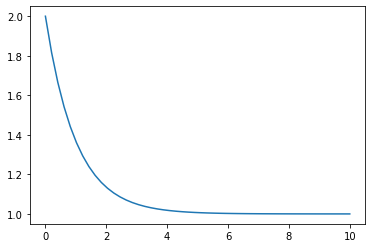

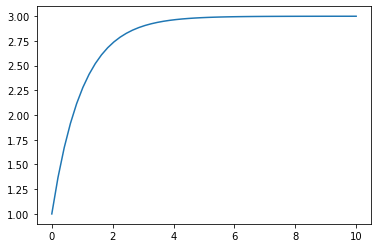

In [11]:
fig,ax = plt.subplots()
x = np.linspace(0,10)
ax.plot(x,monoexp_decay_wint(x,1,1,1))

fig, ax = plt.subplots()
ax.plot(x,monoexp_growth_wint(x,2,1, 1))

In [12]:
KO_sessions = {}
for mouse, sessions in stx.ymaze_sess_deets.KO_sessions.items():
    print(sessions)
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    KO_sessions[mouse] = []
    for deets in sessions:
        print(mouse,deets)
        if isinstance(deets,tuple):
            print('tupe')
            sess_list = []
            for _deets in deets:
                sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,_deets['date'], "%s_%d.pkl" % (_deets['scene'],_deets['session'])),verbose = False)
                antic_consum_licks(sess)
                get_probes_and_omissions(sess)
                single_trial_lick_metrics(sess)
                
                sess_list.append({**_deets, **sess.trial_info })
            combined = combine_sessions(sess_list)
            KO_sessions[mouse].append({**combined, 'trial_number': np.arange(combined['LR'].shape[0])})
        else:
            
            sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),verbose = False)
            antic_consum_licks(sess)
            get_probes_and_omissions(sess)
            single_trial_lick_metrics(sess)

            KO_sessions[mouse].append({**deets, **sess.trial_info, 'trial_number': np.arange(sess.trial_info['LR'].shape[0]) })
    

            

(({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14}), {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 10}), {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}))
4467975.1 ({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan'

In [13]:
CTRL_sessions = {}
for mouse, sessions in stx.ymaze_sess_deets.CTRL_sessions.items():
    print(sessions)
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    CTRL_sessions[mouse] = []
    for deets in sessions:
        print(mouse,deets)
        if isinstance(deets,tuple):
            print('tupe')
            sess_list = []
            for _deets in deets:
                sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,_deets['date'], "%s_%d.pkl" % (_deets['scene'],_deets['session'])),verbose = False)
                antic_consum_licks(sess)
                get_probes_and_omissions(sess)
                single_trial_lick_metrics(sess)
                
                sess_list.append({**_deets, **sess.trial_info })
            combined = combine_sessions(sess_list)
            CTRL_sessions[mouse].append({**combined, 'trial_number': np.arange(combined['LR'].shape[0])})
#             CTRL_sessions[mouse].append(combine_sessions(sess_list))
        else:
            
            sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),verbose = False)
            antic_consum_licks(sess)
            get_probes_and_omissions(sess)
            single_trial_lick_metrics(sess)

#             CTRL_sessions[mouse].append({**deets, **sess.trial_info })
            CTRL_sessions[mouse].append({**deets, **sess.trial_info, 'trial_number': np.arange(sess.trial_info['LR'].shape[0]) })
    


({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}, {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}, {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}), {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 1}, ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}))
4467331.1 {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467331.1 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


4467333.1 ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})
tupe
4467333.1 {'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}
4467333.1 ({'date': '08_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '08_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4})
tupe


In [8]:
KO_sessions['4467975.1'][0].keys()

dict_keys(['date', 'scene', 'session', 'scan', 'block_number', 'LR', 'probes', 'omissions', 'lickrate_rz_early', 'lickrate_rz_late', 'lickrate_dprime', 'lick_acc', 'lick_meanpos', 'lick_varpos', 'trial_number'])

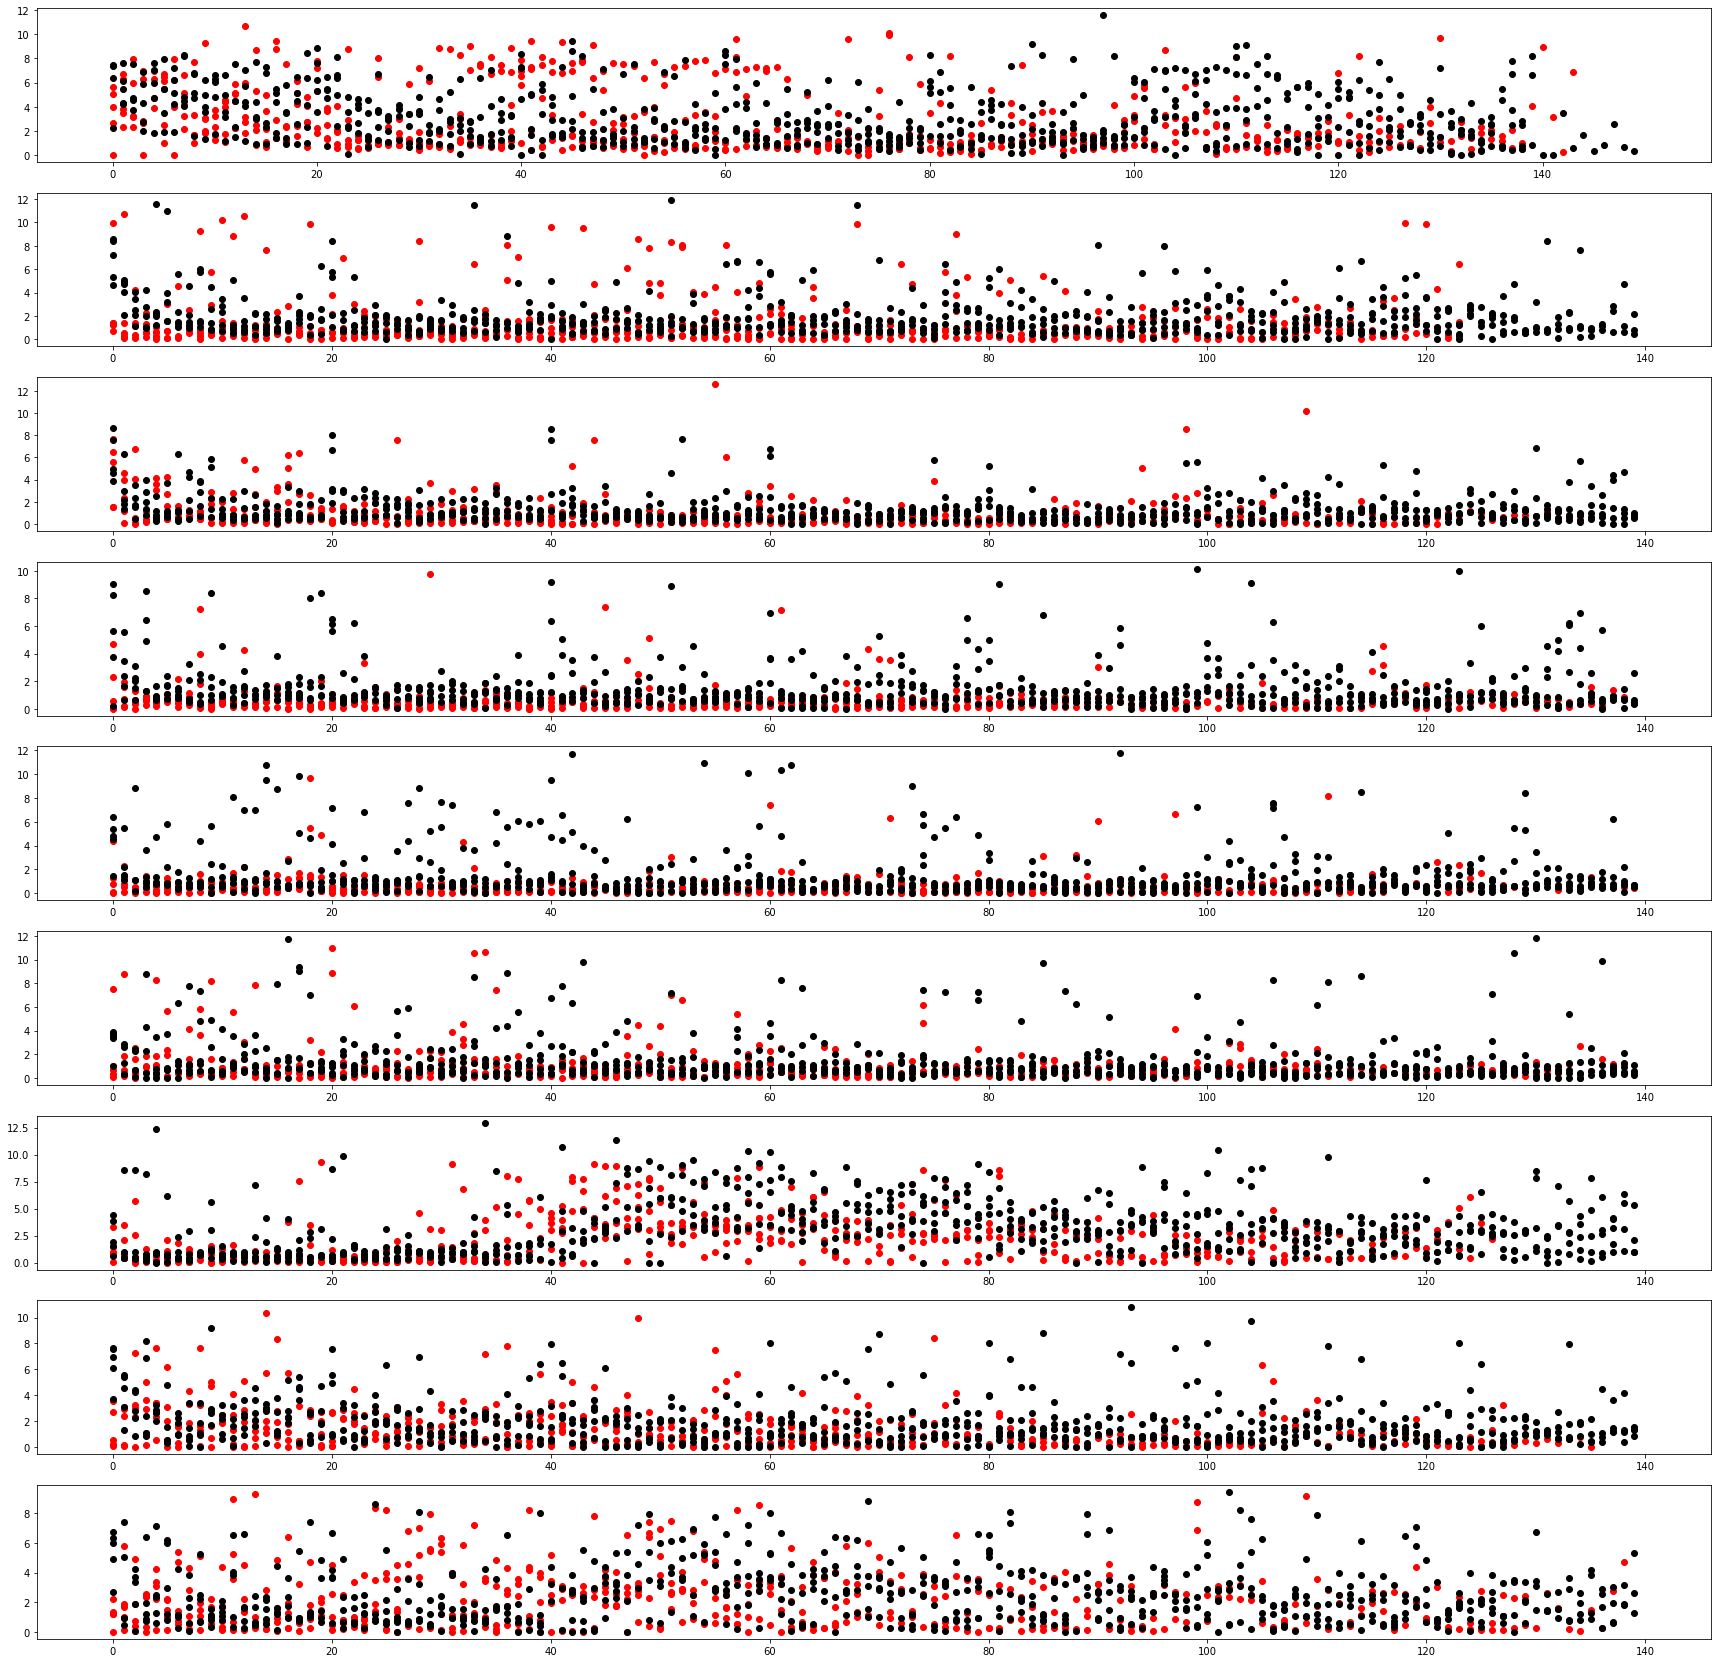

In [32]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
#         ax[j].scatter(d['trial_number'][d['probes']==0],d['lick_varpos'][d['probes']==0], color = 'red')
        ax[j].scatter(d['trial_number'],d['lick_varpos'], color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
#         ax[j].scatter(d['trial_number'][d['probes']==0],d['lick_varpos'][d['probes']==0], color = 'black')
        ax[j].scatter(d['trial_number'],d['lick_varpos'], color = 'black')
    



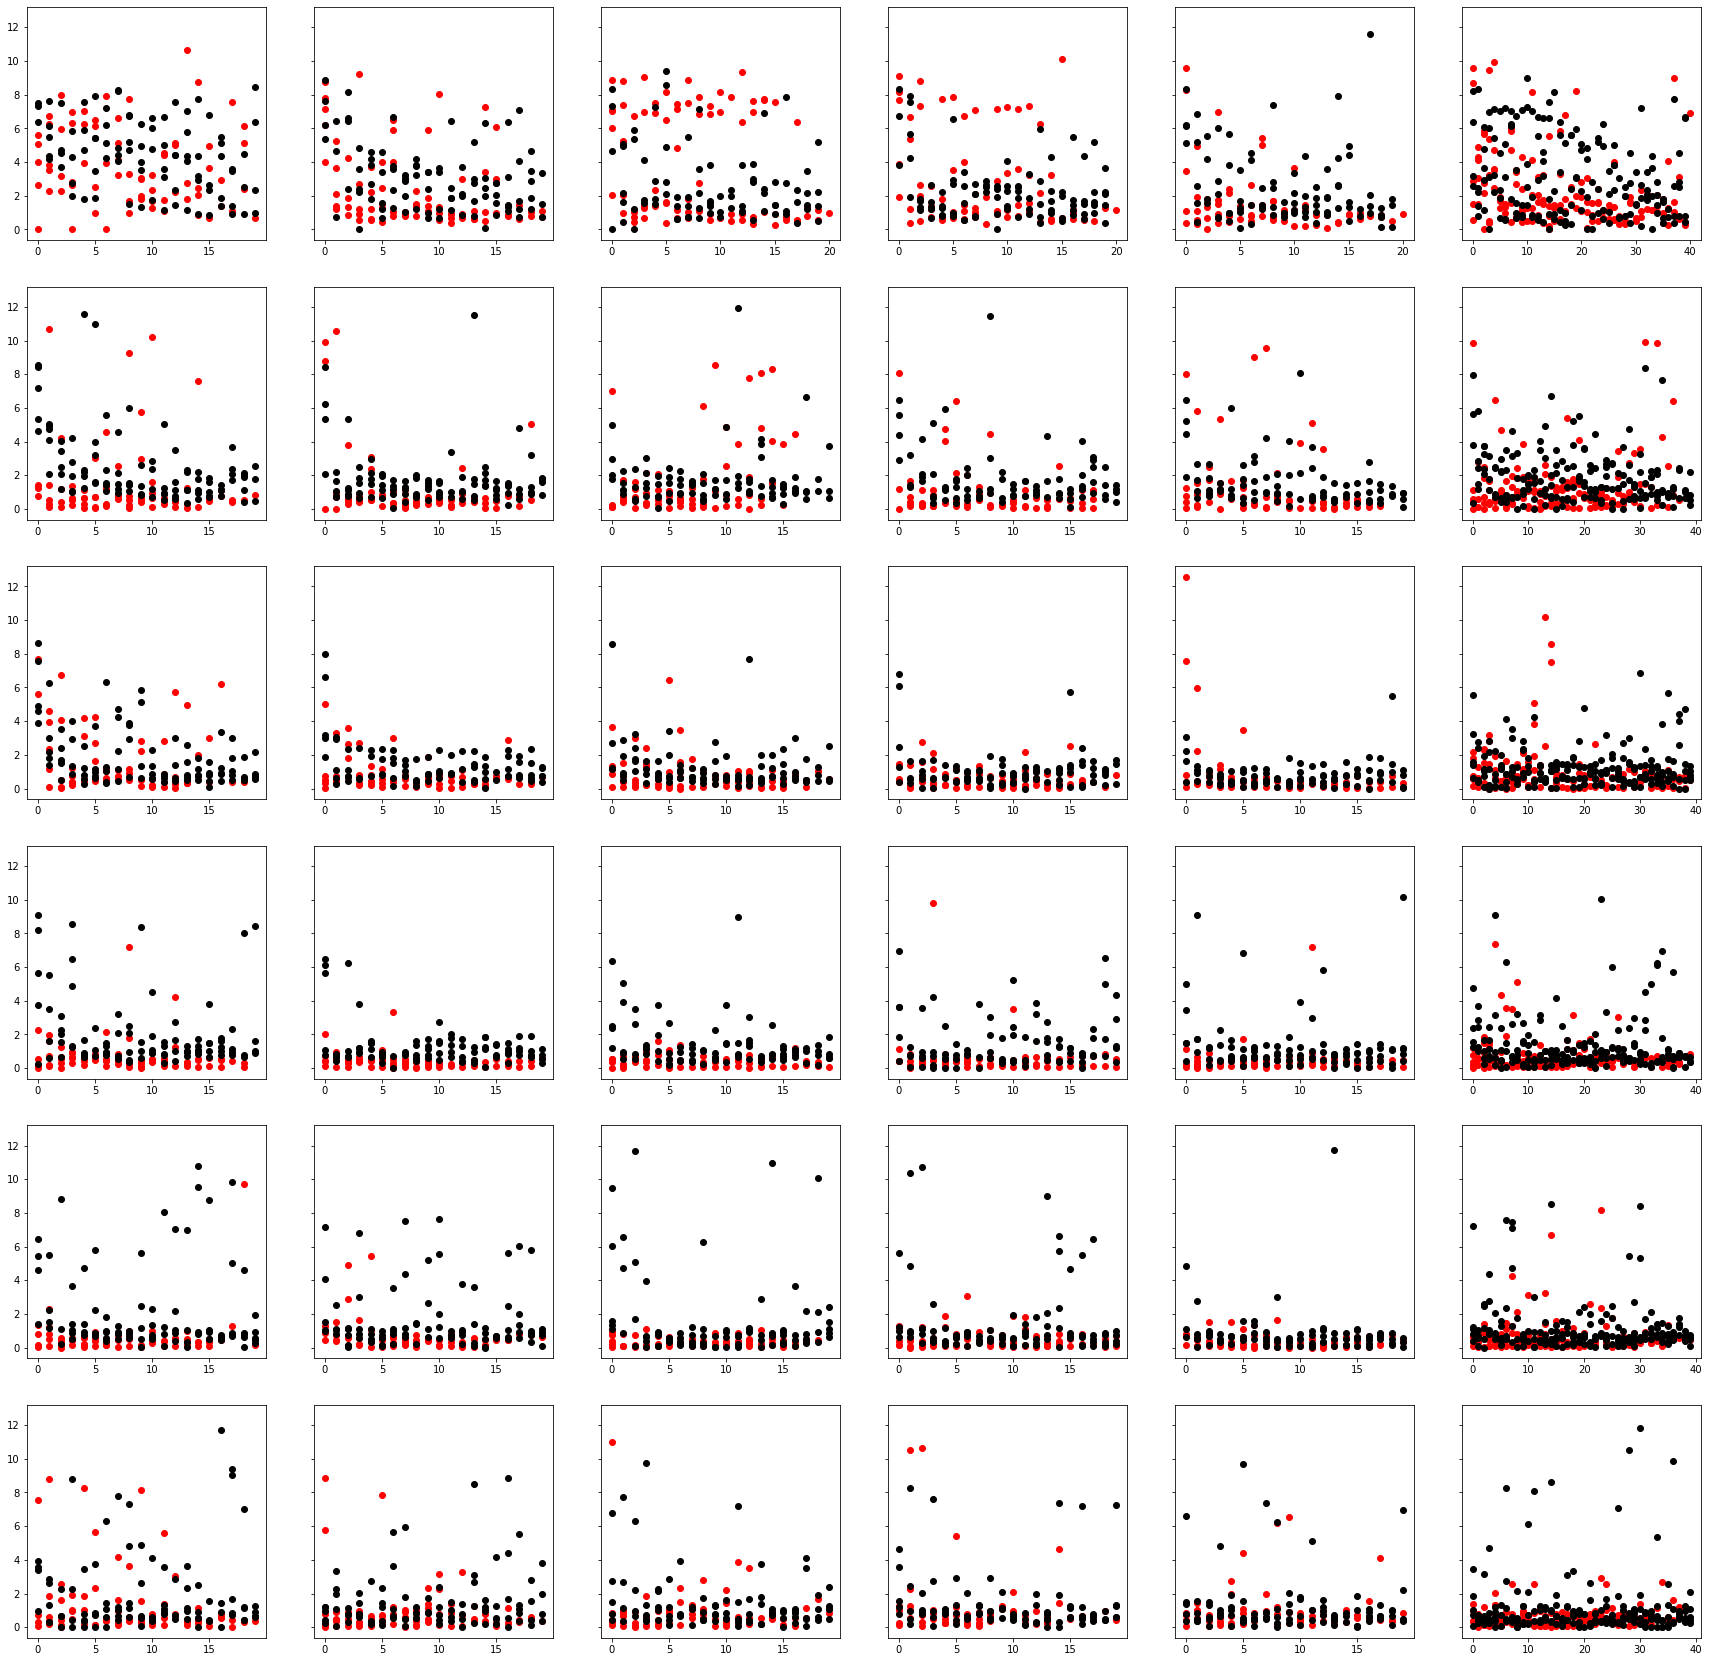

In [10]:
fig,ax = plt.subplots(6,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:6]):
        
#         _block_trial_start = 0
        for block in range(6):
            block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = d['lick_varpos'][block_mask]
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:6]):
        
#         _block_trial_start = 0
        for block in range(6):
            
            block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = d['lick_varpos'][block_mask]
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])
    

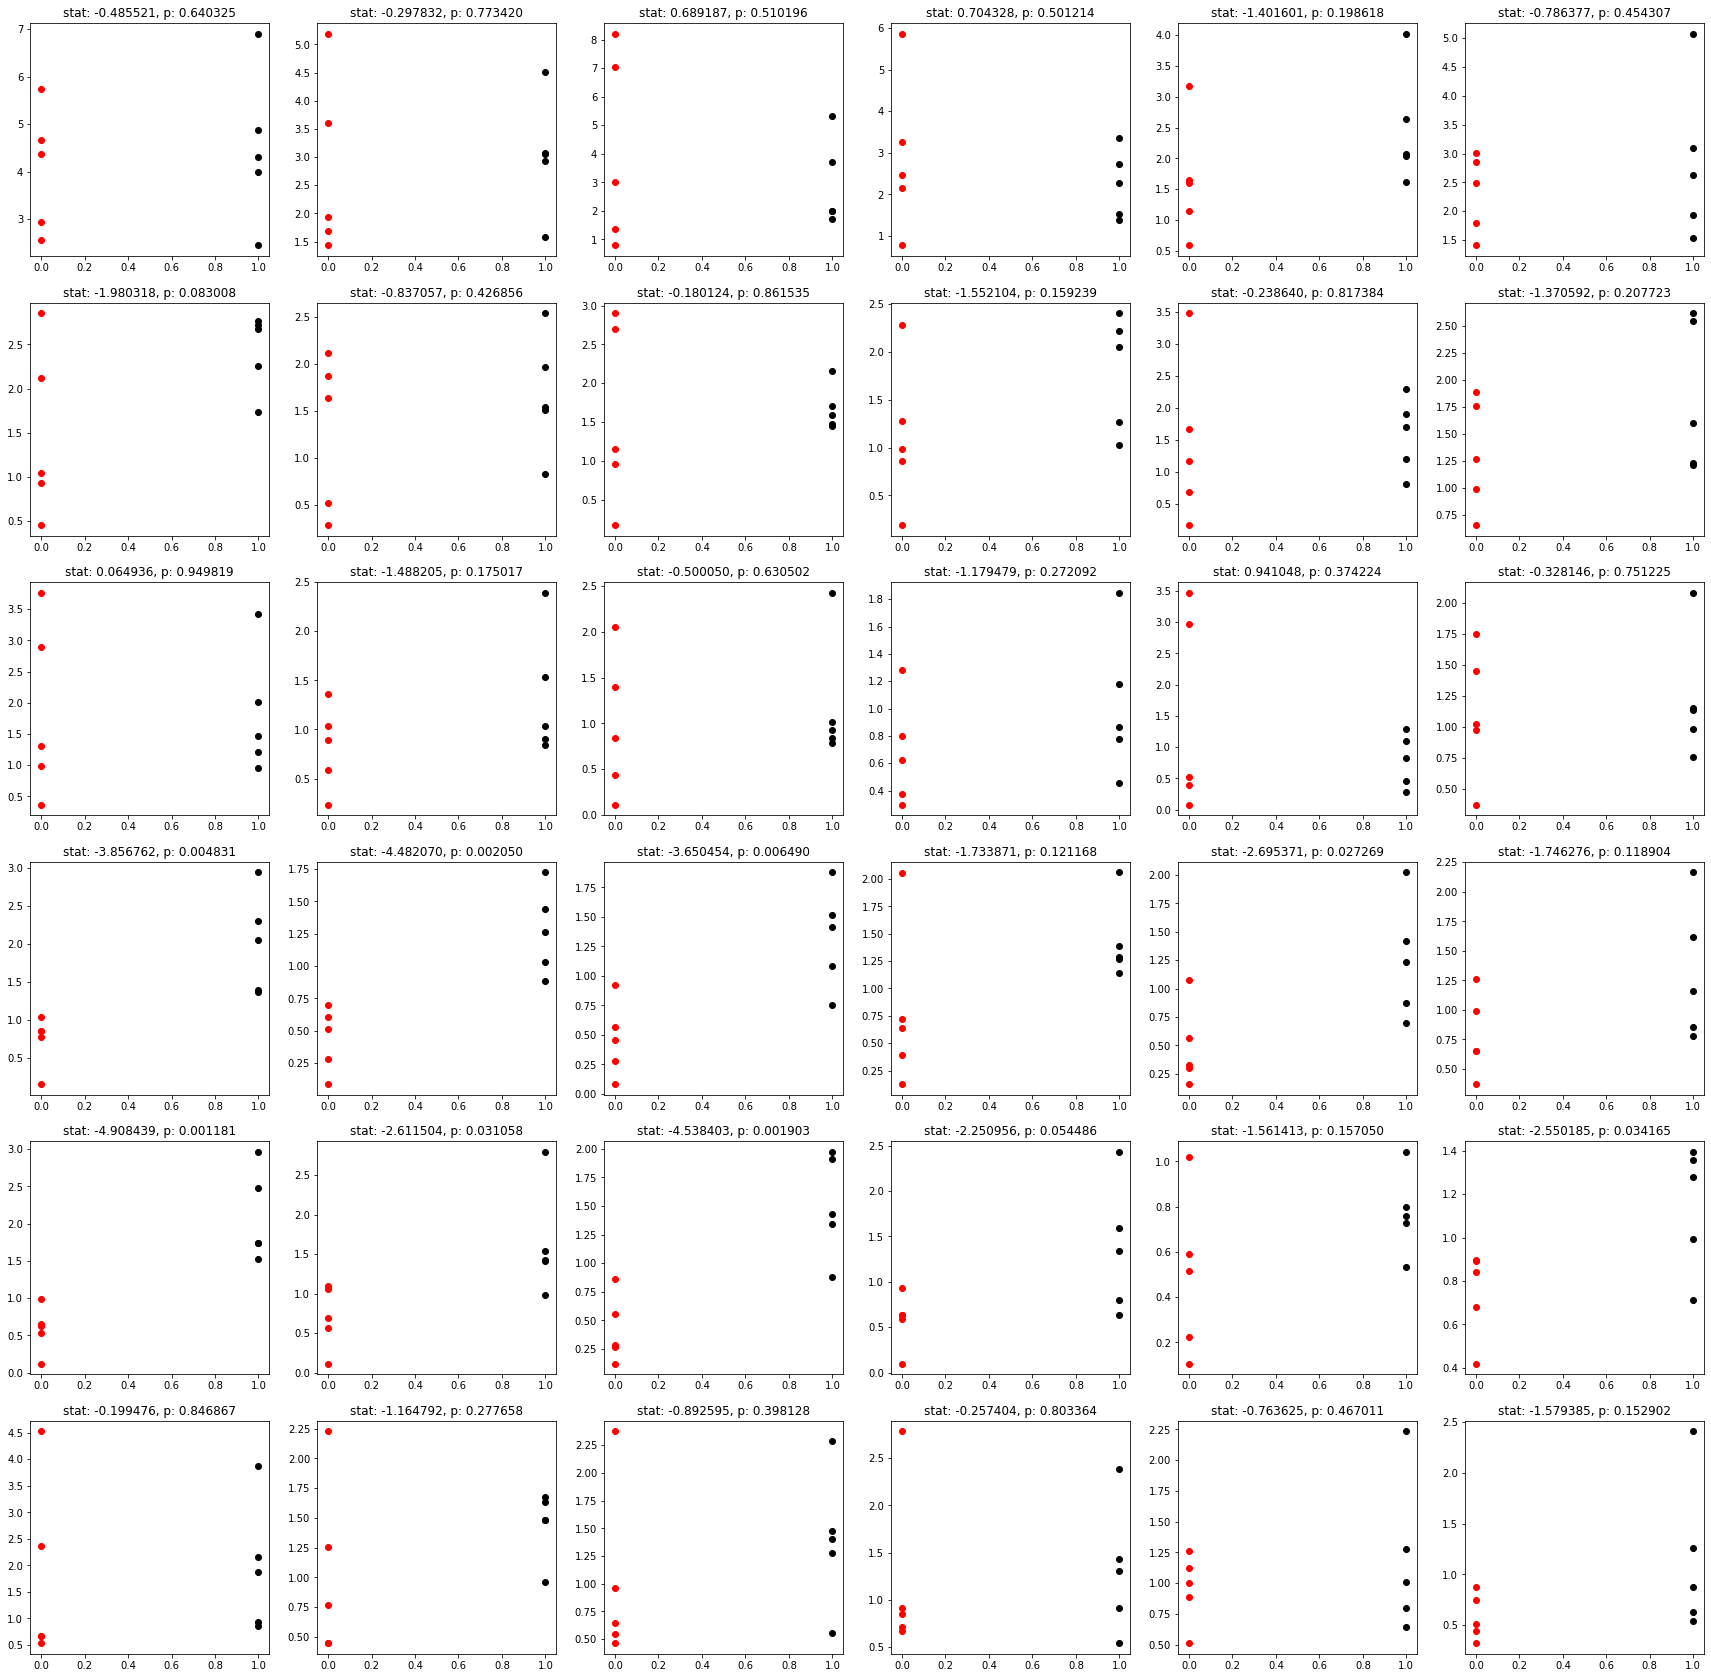

In [11]:
fig,ax = plt.subplots(6,6,figsize=[30,30])

for row in range(6):
    for col in range(6):
        ax[row,col].scatter(np.zeros([5,]), KO_vars[:,row,col],color='red')
        ax[row,col].scatter(np.ones([5,]), CTRL_vars[:,row,col],color='black')
#         stat,p = sp.stats.ranksums(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        stat,p = sp.stats.ttest_ind(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        ax[row,col].set_title("stat: %f, p: %f" % (stat,p))

In [12]:
stat,p = sp.stats.ttest_ind(KO_vars.mean(axis=-1).mean(axis=-1).ravel() ,CTRL_vars.mean(axis=-1).mean(axis=-1).ravel())
print(stat,p)

-1.624666452776021 0.14288805786255518


40
4467331.1 17
40
4467331.2 17
40
4467332.1 19
40
4467332.2 18
40
4467333.1 18


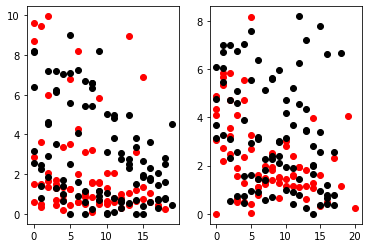

In [13]:
# day 1 novel arm test
fig,ax = plt.subplots(1,2)
KO_vars = np.zeros([5,2])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    fam_arm = d_list[0]['LR'][0]
    nov_arm = fam_arm*-1
    d = d_list[0]
#     for j,d in enumerate(d_list[:6]):
    block = 5
    block_mask = d['block_number']==block

    lick_varpos = d['lick_varpos'][block_mask]
    probes = d['probes'][block_mask]
    lr = d['LR'][block_mask]

    fam_mask = (lr==fam_arm) & (probes==0)
    
    nov_mask = (lr==nov_arm) & (probes==0)
    ax[0].scatter(np.arange(fam_mask.sum()),lick_varpos[fam_mask],color='red')
    ax[1].scatter(np.arange(nov_mask.sum()),lick_varpos[nov_mask],color='red')

    fam_var = lick_varpos[(lr==fam_arm) & (probes==0)]
    KO_vars[i,0] = np.nanmean(fam_var)
    nov_var = lick_varpos[(lr==nov_arm) & (probes==0)]
    KO_vars[i,1] = np.nanmean(nov_var)
        
CTRL_vars = np.zeros([5,2])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    fam_arm = d_list[0]['LR'][0]
    nov_arm = fam_arm*-1
    d = d_list[0]
#     for j,d in enumerate(d_list[:6]):
    if mouse == '4467332.2':
        block=6
    else:
        block = 5
    block_mask = d['block_number']==block
    print(block_mask.sum())

    lick_varpos = d['lick_varpos'][block_mask]
    probes = d['probes'][block_mask]
    lr = d['LR'][block_mask]

    fam_mask = (lr==fam_arm) & (probes==0)
    nov_mask = (lr==nov_arm) & (probes==0)
    print(mouse,nov_mask.sum())
    ax[0].scatter(np.arange(fam_mask.sum()),lick_varpos[fam_mask],color='black')
    ax[1].scatter(np.arange(nov_mask.sum()),lick_varpos[nov_mask],color='black')

    fam_var = lick_varpos[(lr==fam_arm) & (probes==0)]
    CTRL_vars[i,0] = np.nanmean(fam_var)
    nov_var = lick_varpos[(lr==nov_arm) & (probes==0)]
    CTRL_vars[i,1] = np.nanmean(nov_var)
        

Text(0.5, 1.0, 'stat: -1.487968, p: 0.175078')

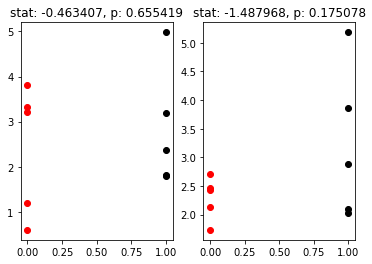

In [14]:
fig,ax = plt.subplots(1,2)
ax[0].scatter(np.zeros([5,]), KO_vars[:,0],color='red')
ax[0].scatter(np.ones([5,]), CTRL_vars[:,0],color='black')
# stat,p = sp.stats.ranksums(KO_vars[:,0].ravel() ,CTRL_vars[:,0].ravel())
stat,p = sp.stats.ttest_ind(KO_vars[:,0].ravel() ,CTRL_vars[:,0].ravel())
ax[0].set_title("stat: %f, p: %f" % (stat,p))

ax[1].scatter(np.zeros([5,]), KO_vars[:,1],color='red')
ax[1].scatter(np.ones([5,]), CTRL_vars[:,1],color='black')
# stat,p = sp.stats.ranksums(KO_vars[:,1].ravel() ,CTRL_vars[:,1].ravel())
stat,p = sp.stats.ttest_ind(KO_vars[:,1].ravel() ,CTRL_vars[:,1].ravel())
ax[1].set_title("stat: %f, p: %f" % (stat,p))

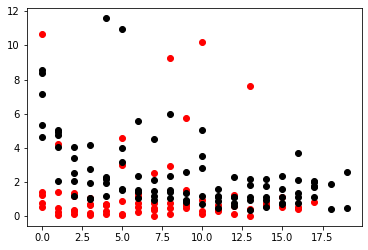

In [15]:
fig,ax = plt.subplots()
KO_vars = np.zeros([5,])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    fam_arm = d_list[0]['LR'][0]
    nov_arm = fam_arm*-1
    d = d_list[1]
#     for j,d in enumerate(d_list[:6]):
    block = 0
    block_mask = d['block_number']==block

    lick_varpos = d['lick_varpos'][block_mask]
    probes = d['probes'][block_mask]
    lr = d['LR'][block_mask]
    
    block_mask = probes==0
    
    ax.scatter(np.arange(block_mask.sum()),lick_varpos[block_mask],color='red')
    
    fam_var = lick_varpos[block_mask]
    KO_vars[i] = np.nanmean(fam_var)
    
CTRL_vars = np.zeros([5,])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    fam_arm = d_list[0]['LR'][0]
    nov_arm = fam_arm*-1
    d = d_list[1]
#     for j,d in enumerate(d_list[:6]):
    block = 0
    block_mask = d['block_number']==block

    lick_varpos = d['lick_varpos'][block_mask]
    probes = d['probes'][block_mask]
    lr = d['LR'][block_mask]
    
    block_mask = probes==0
    
    ax.scatter(np.arange(block_mask.sum()),lick_varpos[block_mask],color='black')
    
    fam_var = lick_varpos[block_mask]
    CTRL_vars[i] = np.nanmean(fam_var)
    
        

In [16]:
# look at other metrics

# analyze probe trials

# first 5 trials of each block


<ipython-input-33-0cb915dfdd55>:5: RuntimeWarning: divide by zero encountered in log
  ax[j].scatter(d['trial_number'][d['probes']==0],np.log(d['lick_acc'][d['probes']==0]), color = 'red')
<ipython-input-33-0cb915dfdd55>:9: RuntimeWarning: divide by zero encountered in log
  ax[j].scatter(d['trial_number'][d['probes']==0],np.log(d['lick_acc'][d['probes']==0]), color = 'black')


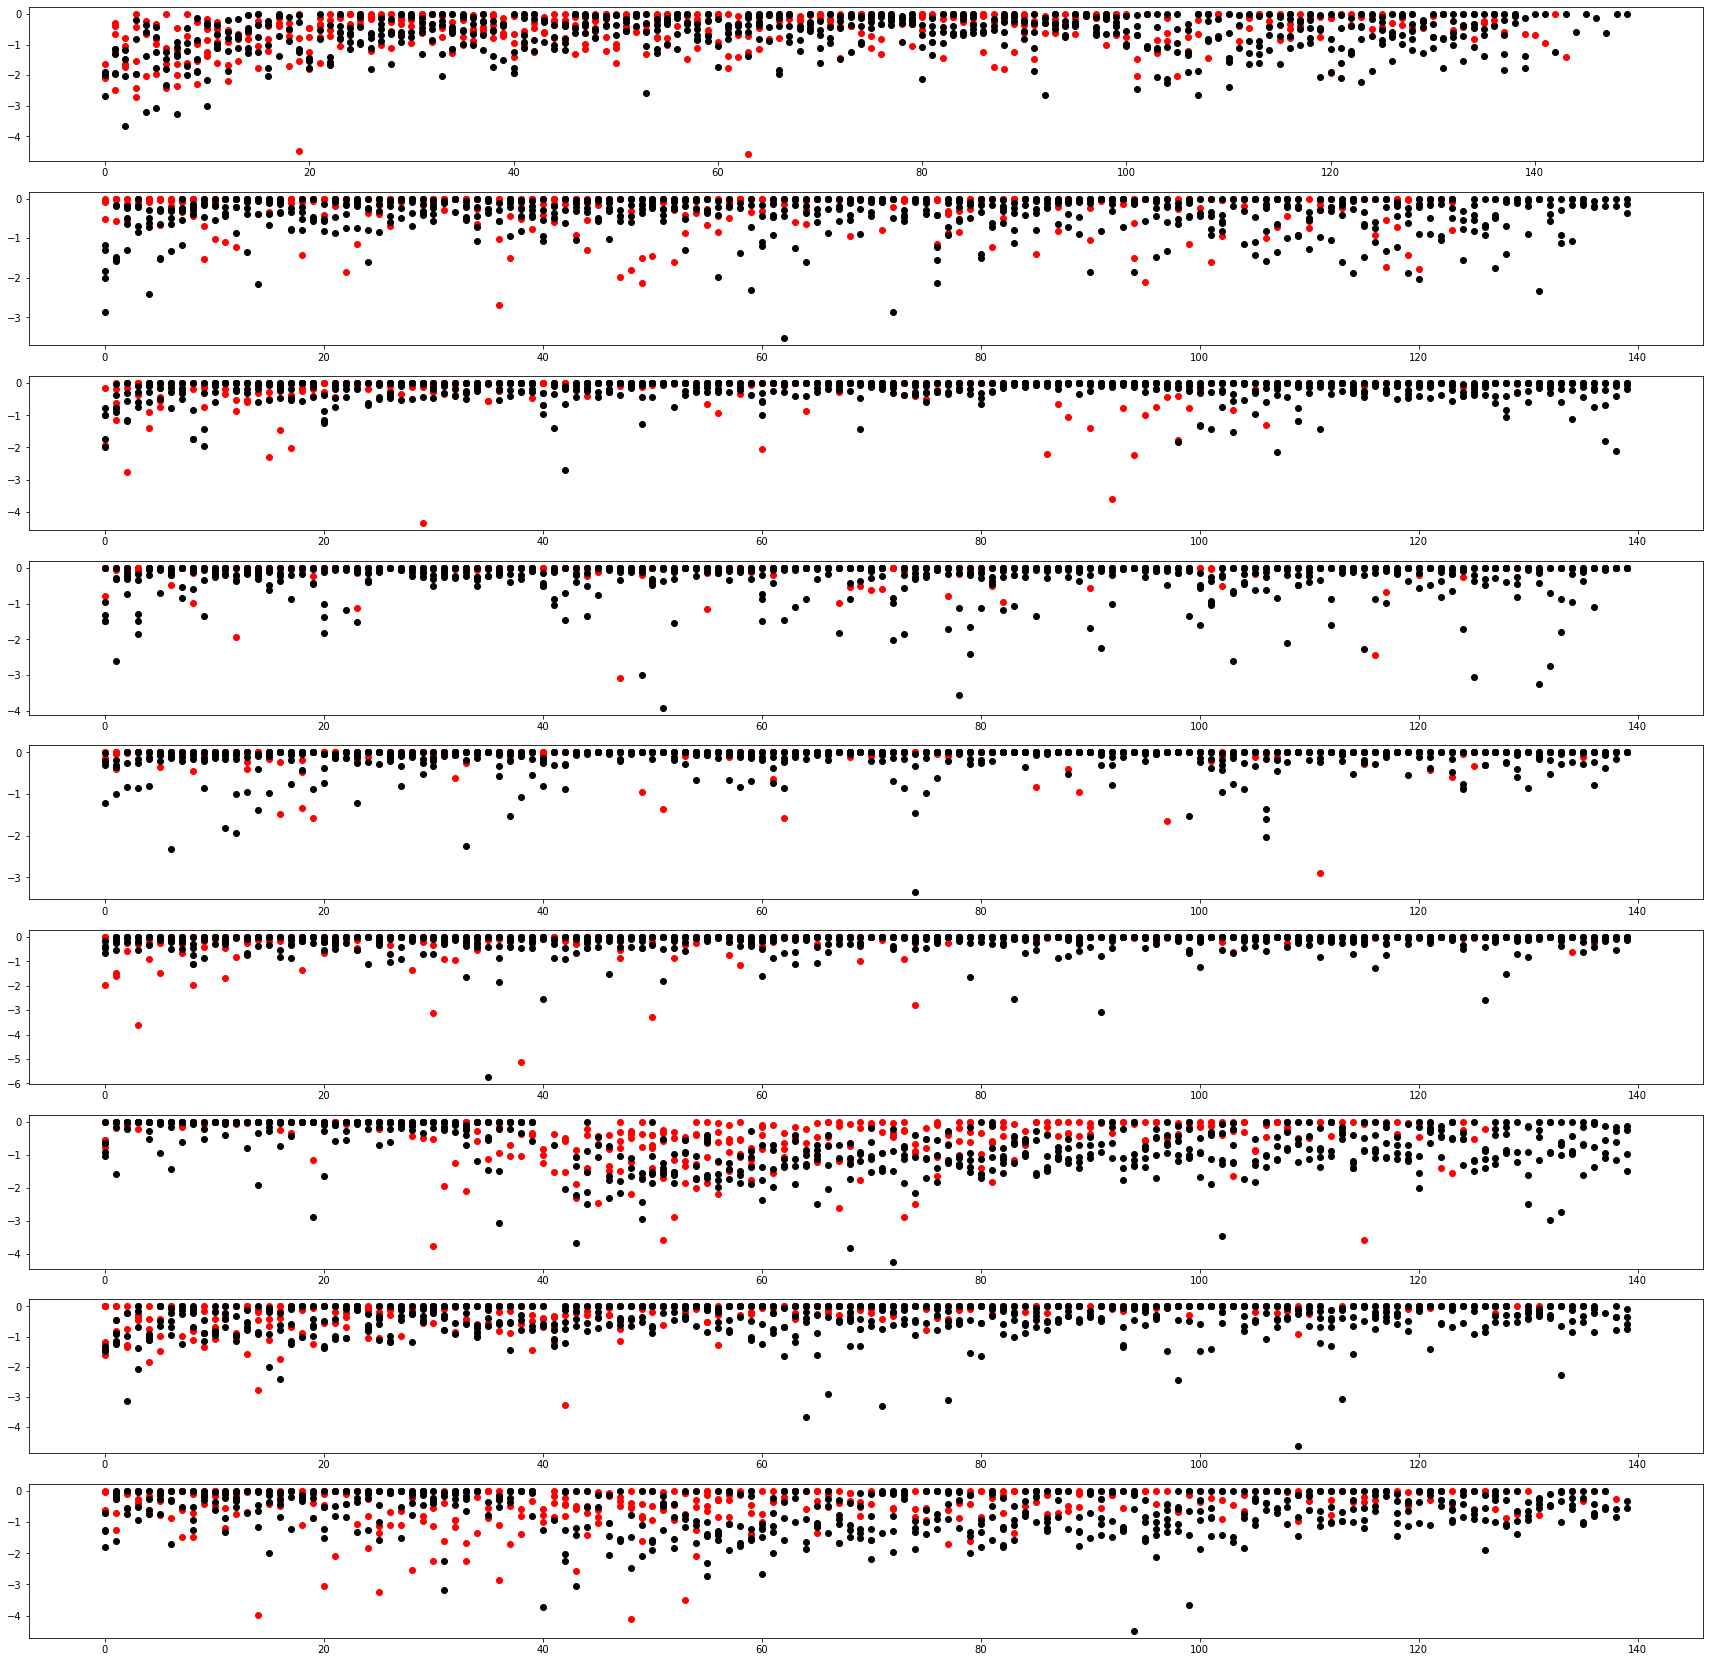

In [33]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['probes']==0],np.log(d['lick_acc'][d['probes']==0]), color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['probes']==0],np.log(d['lick_acc'][d['probes']==0]), color = 'black')
    


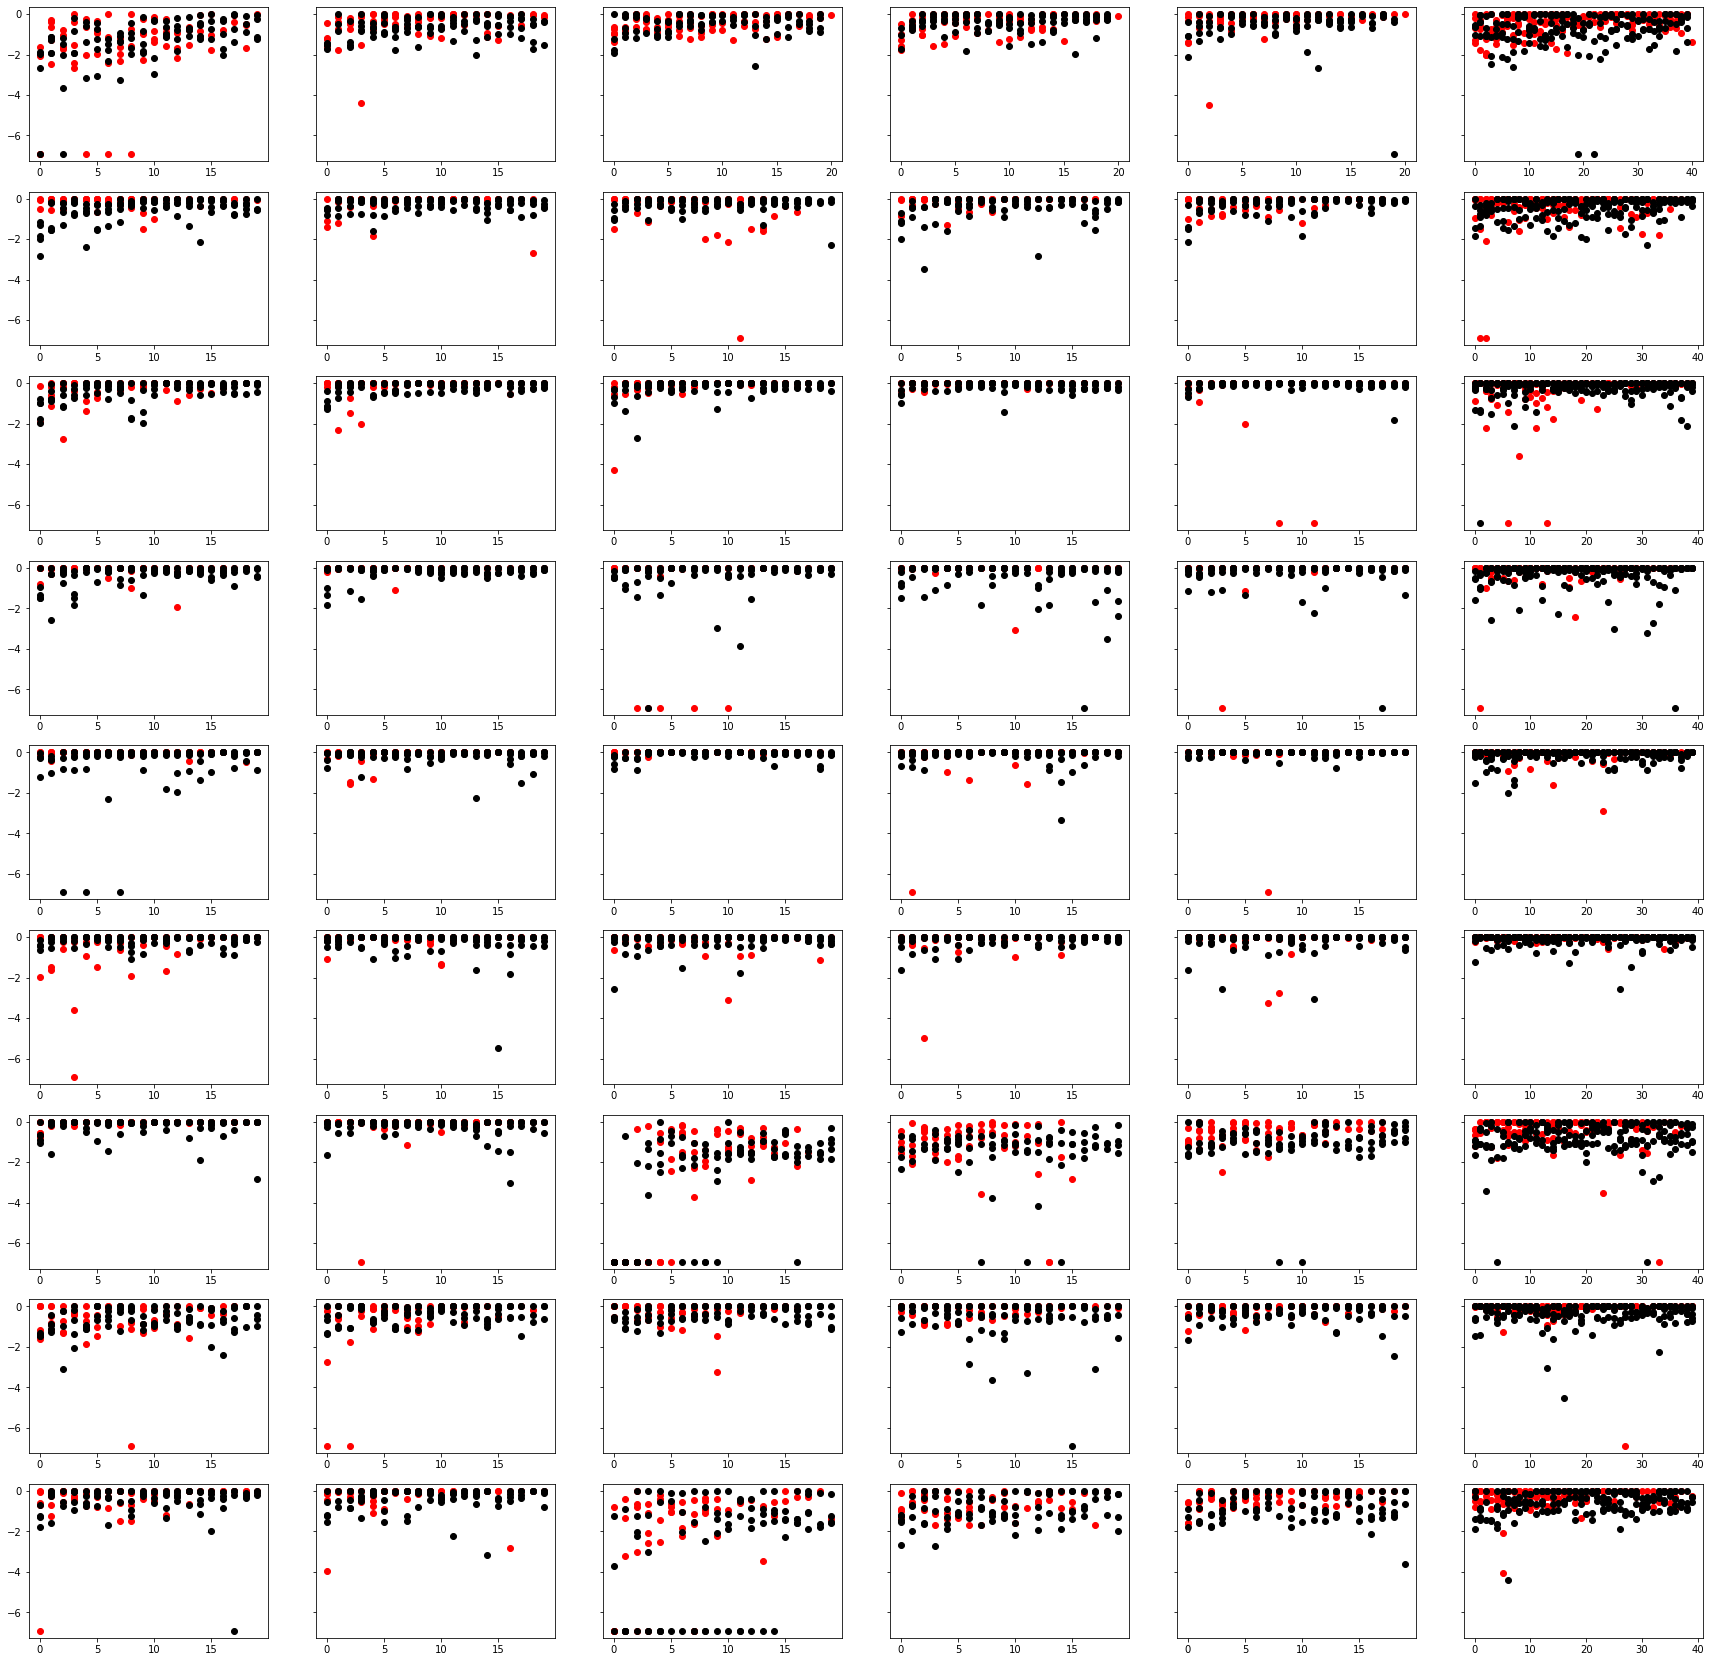

In [18]:
fig,ax = plt.subplots(9,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,9,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list):
        
#         _block_trial_start = 0
        for block in range(6):
            block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = np.log(d['lick_acc'][block_mask]+1E-3)
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,9,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list):
        
#         _block_trial_start = 0
        for block in range(6):
            
            block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = np.log(d['lick_acc'][block_mask]+1E-3)
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

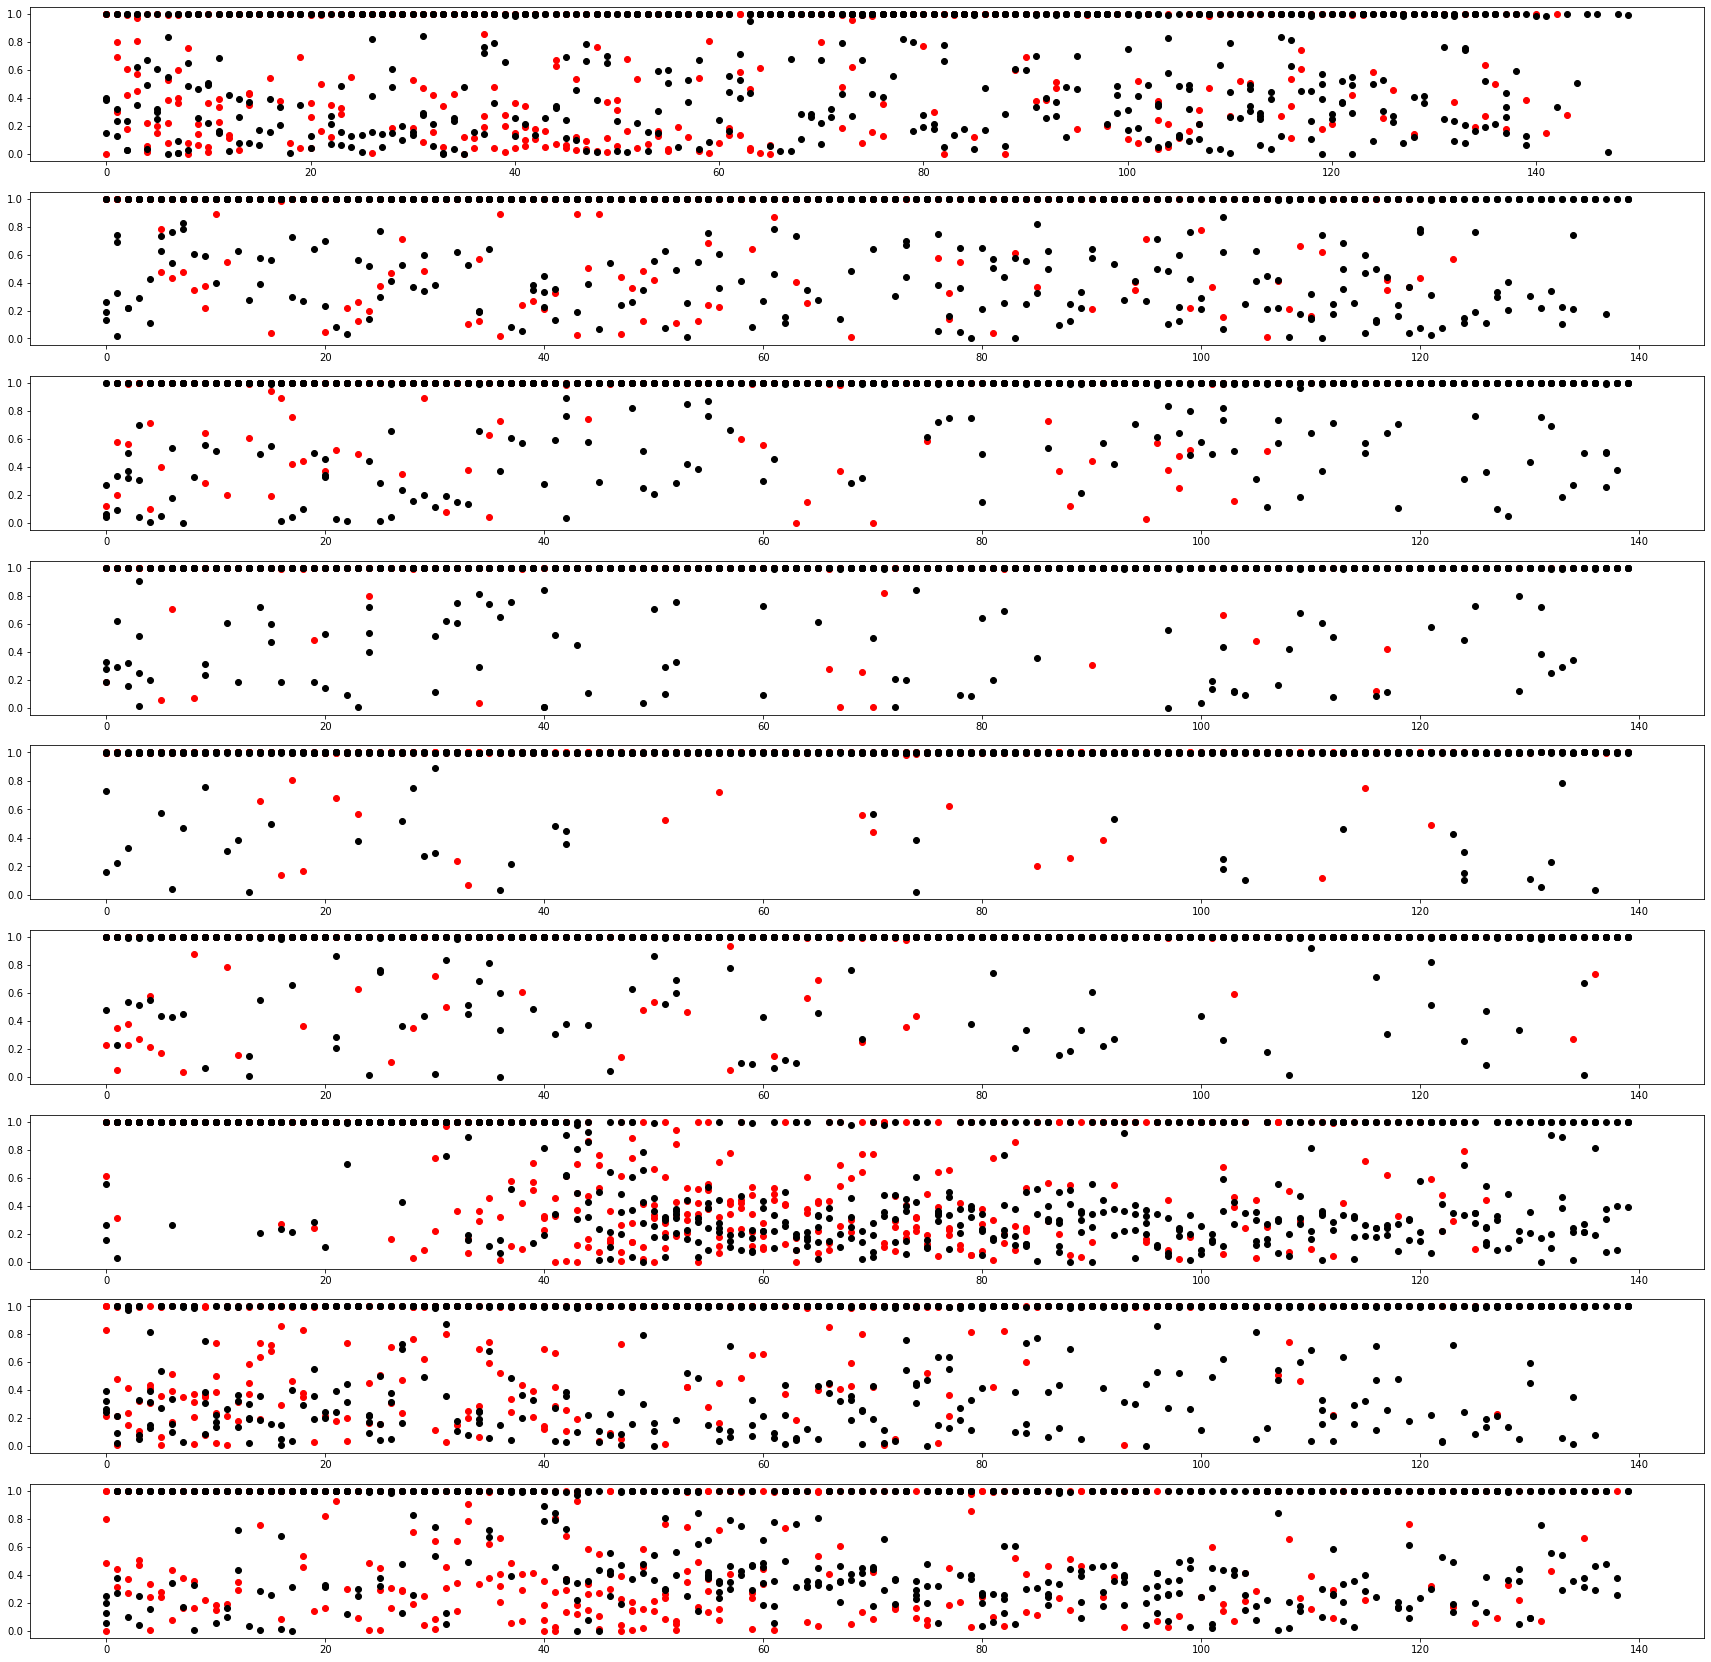

In [19]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['probes']==0],np.abs(d['lickrate_dprime'][d['probes']==0]), color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['probes']==0],np.abs(d['lickrate_dprime'][d['probes']==0]), color = 'black')
    


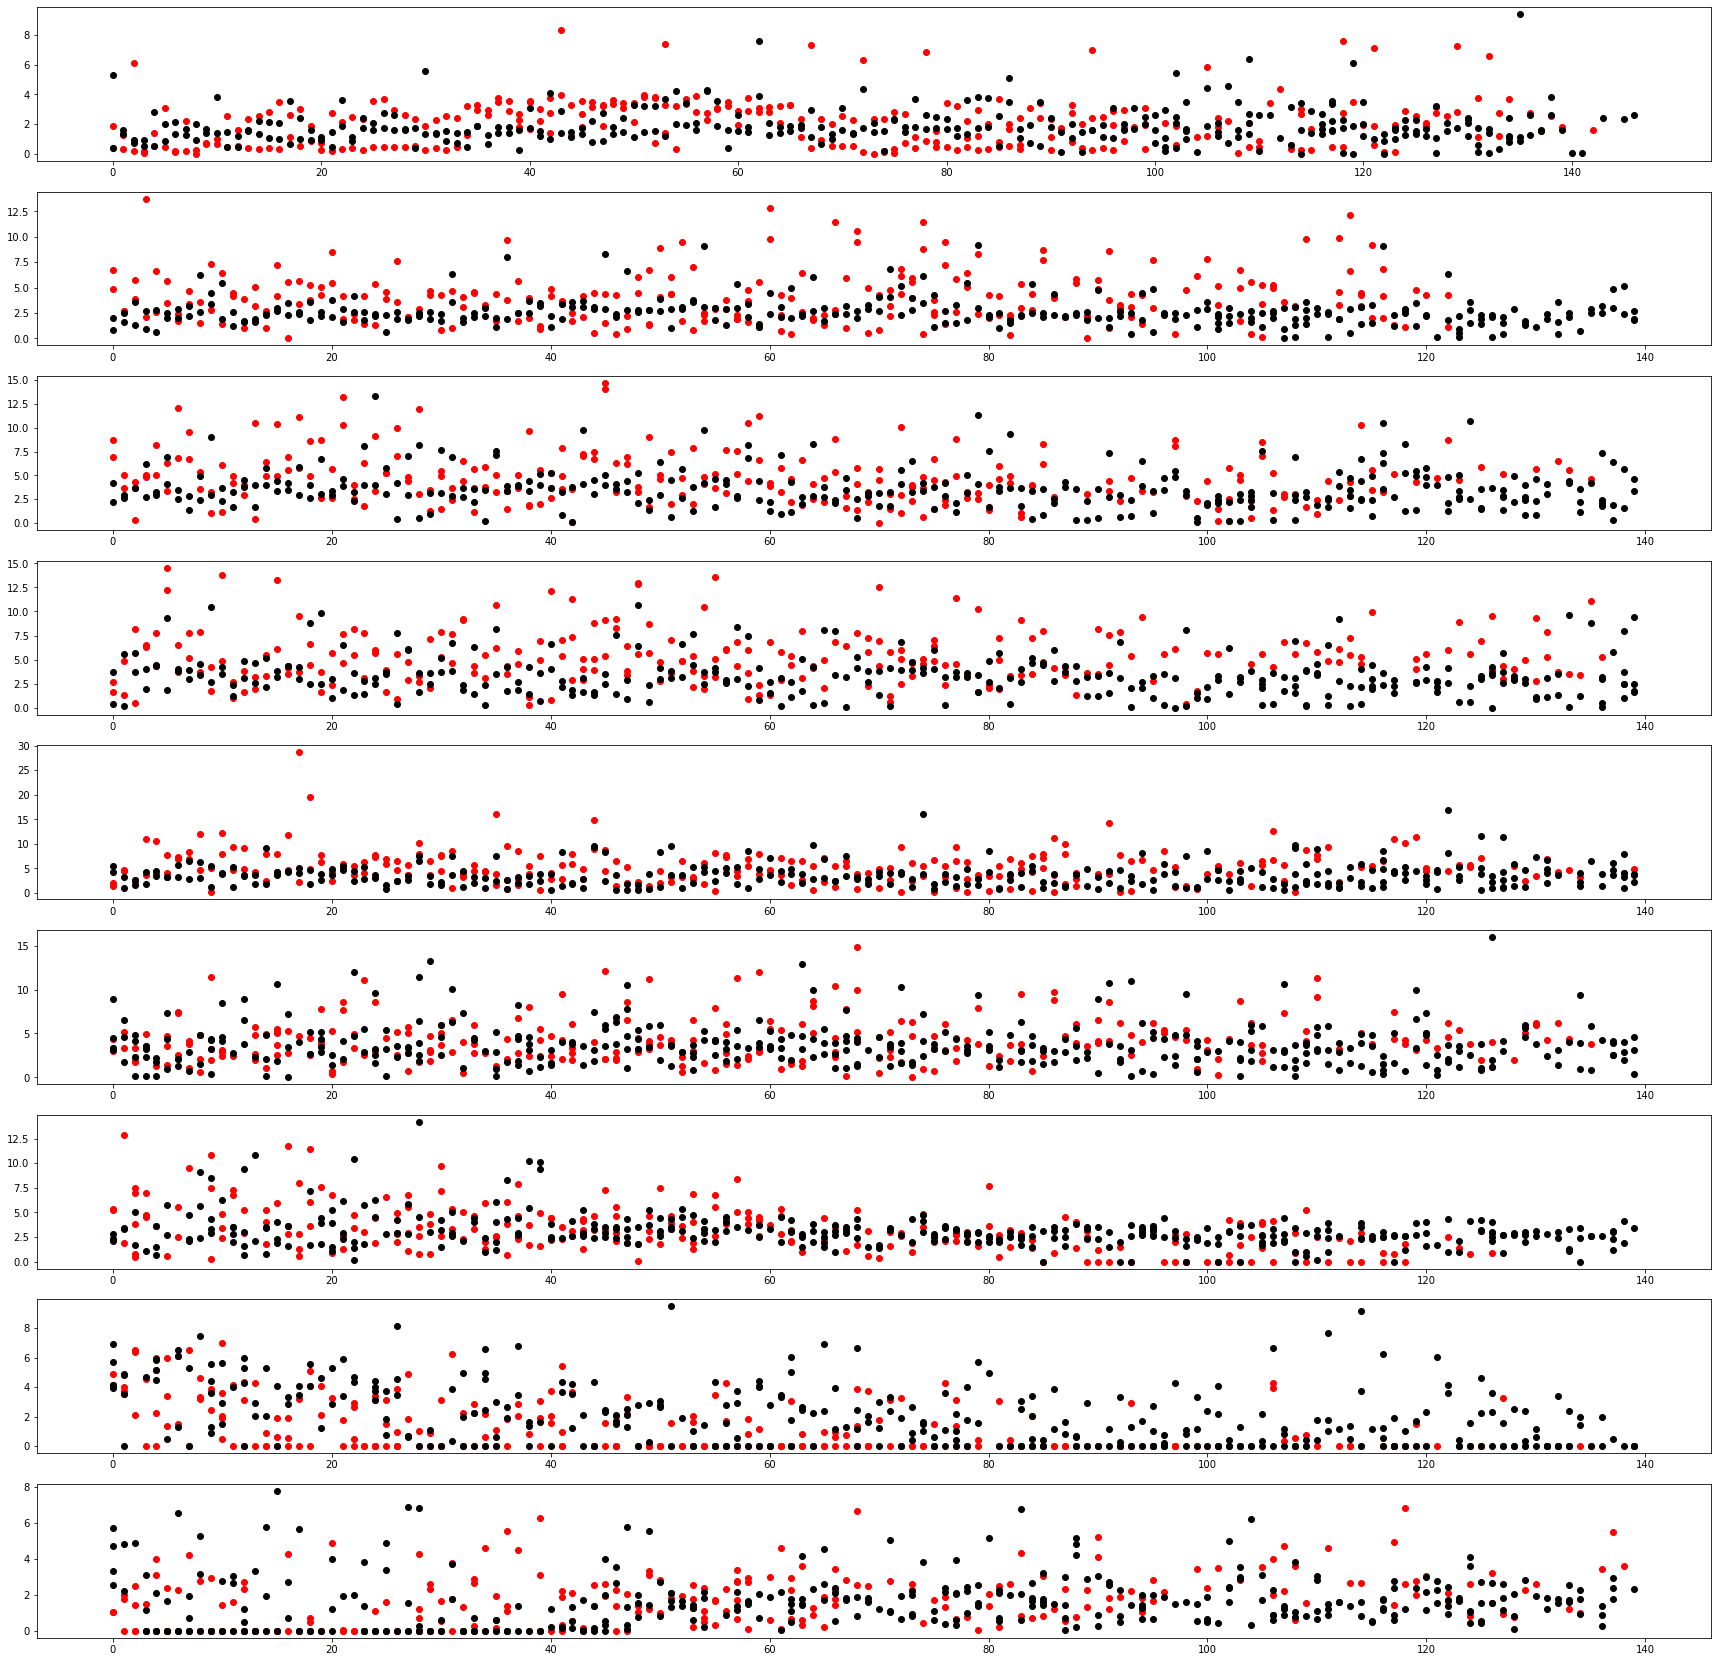

In [20]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'black')
    


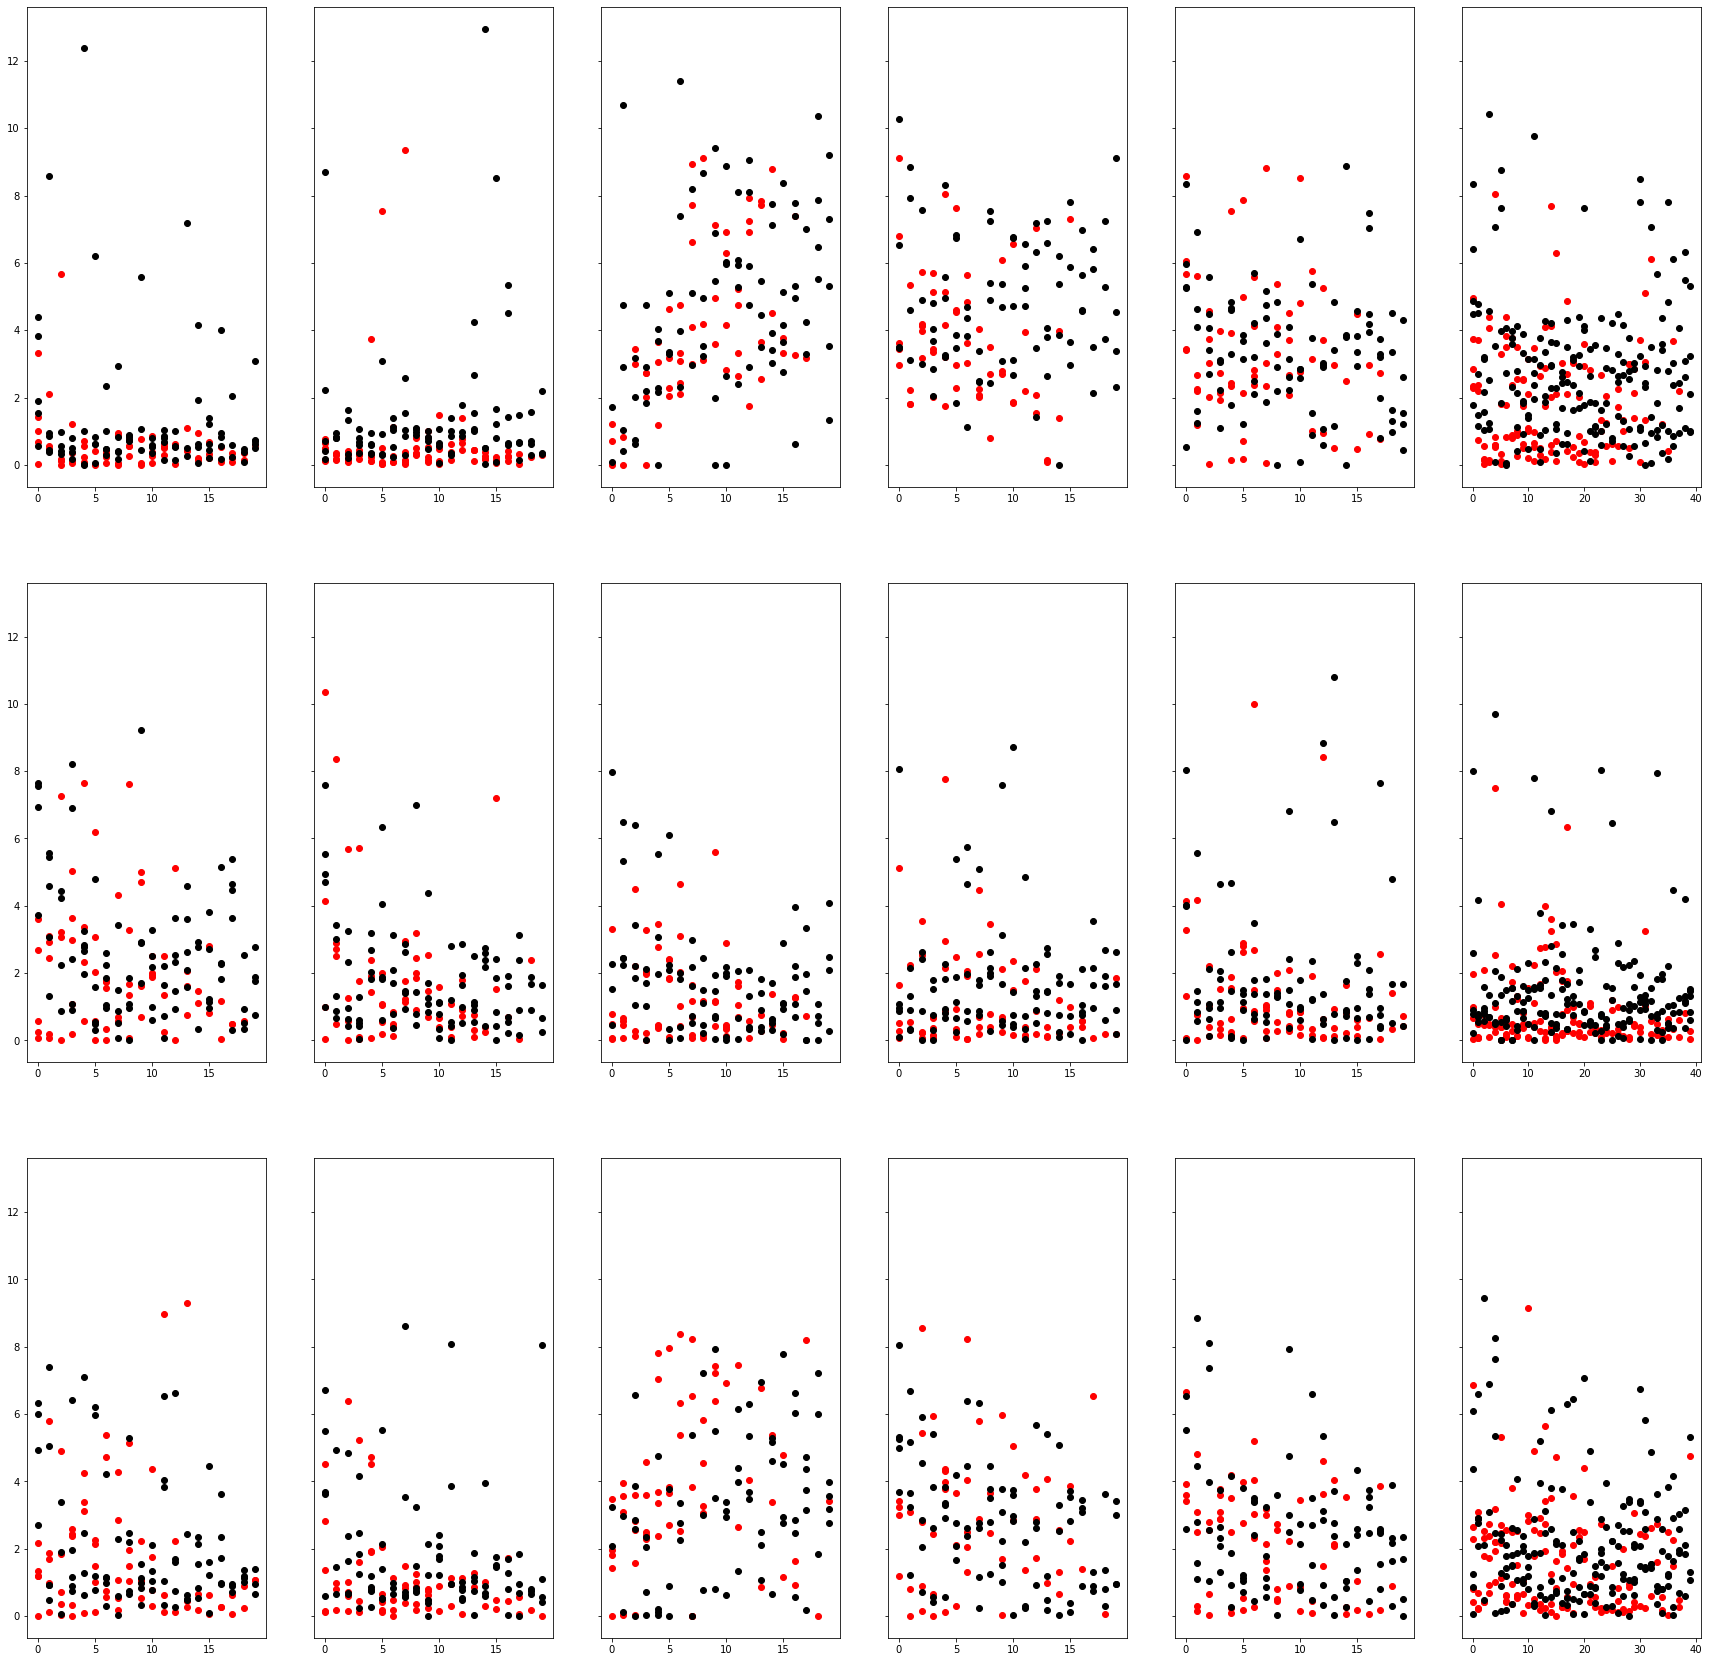

In [21]:
fig,ax = plt.subplots(3,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,3,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = d['lick_varpos'][block_mask]
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            
            block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = d['lick_varpos'][block_mask]
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

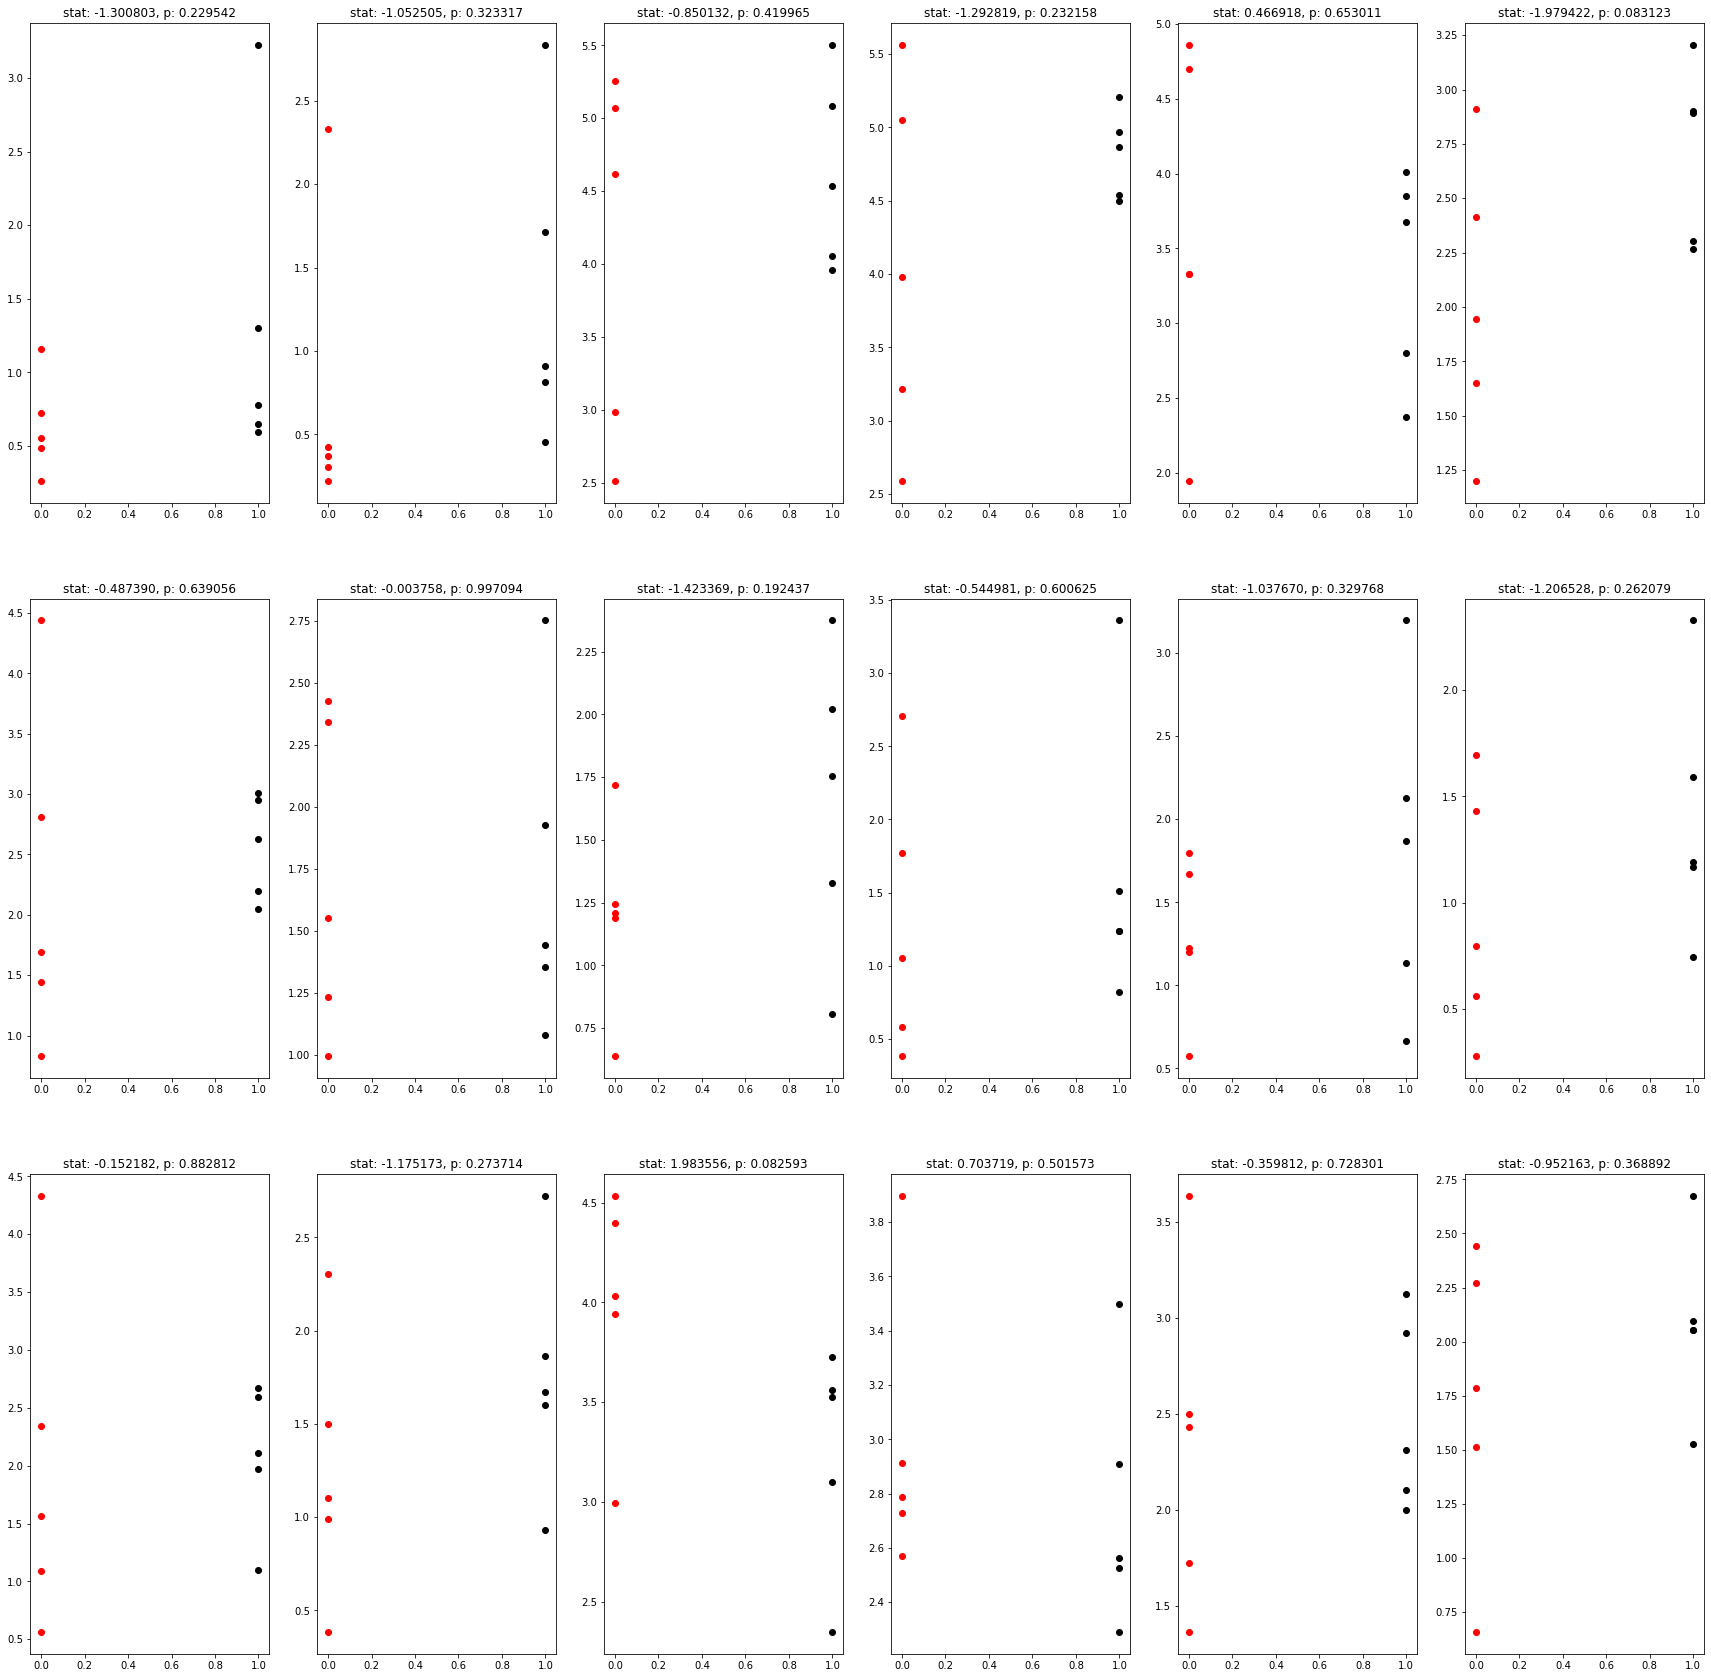

In [22]:
fig,ax = plt.subplots(3,6,figsize=[30,30])

for row in range(3):
    for col in range(6):
        ax[row,col].scatter(np.zeros([5,]), KO_vars[:,row,col],color='red')
        ax[row,col].scatter(np.ones([5,]), CTRL_vars[:,row,col],color='black')
#         stat,p = sp.stats.ranksums(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        stat,p = sp.stats.ttest_ind(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        ax[row,col].set_title("stat: %f, p: %f" % (stat,p))

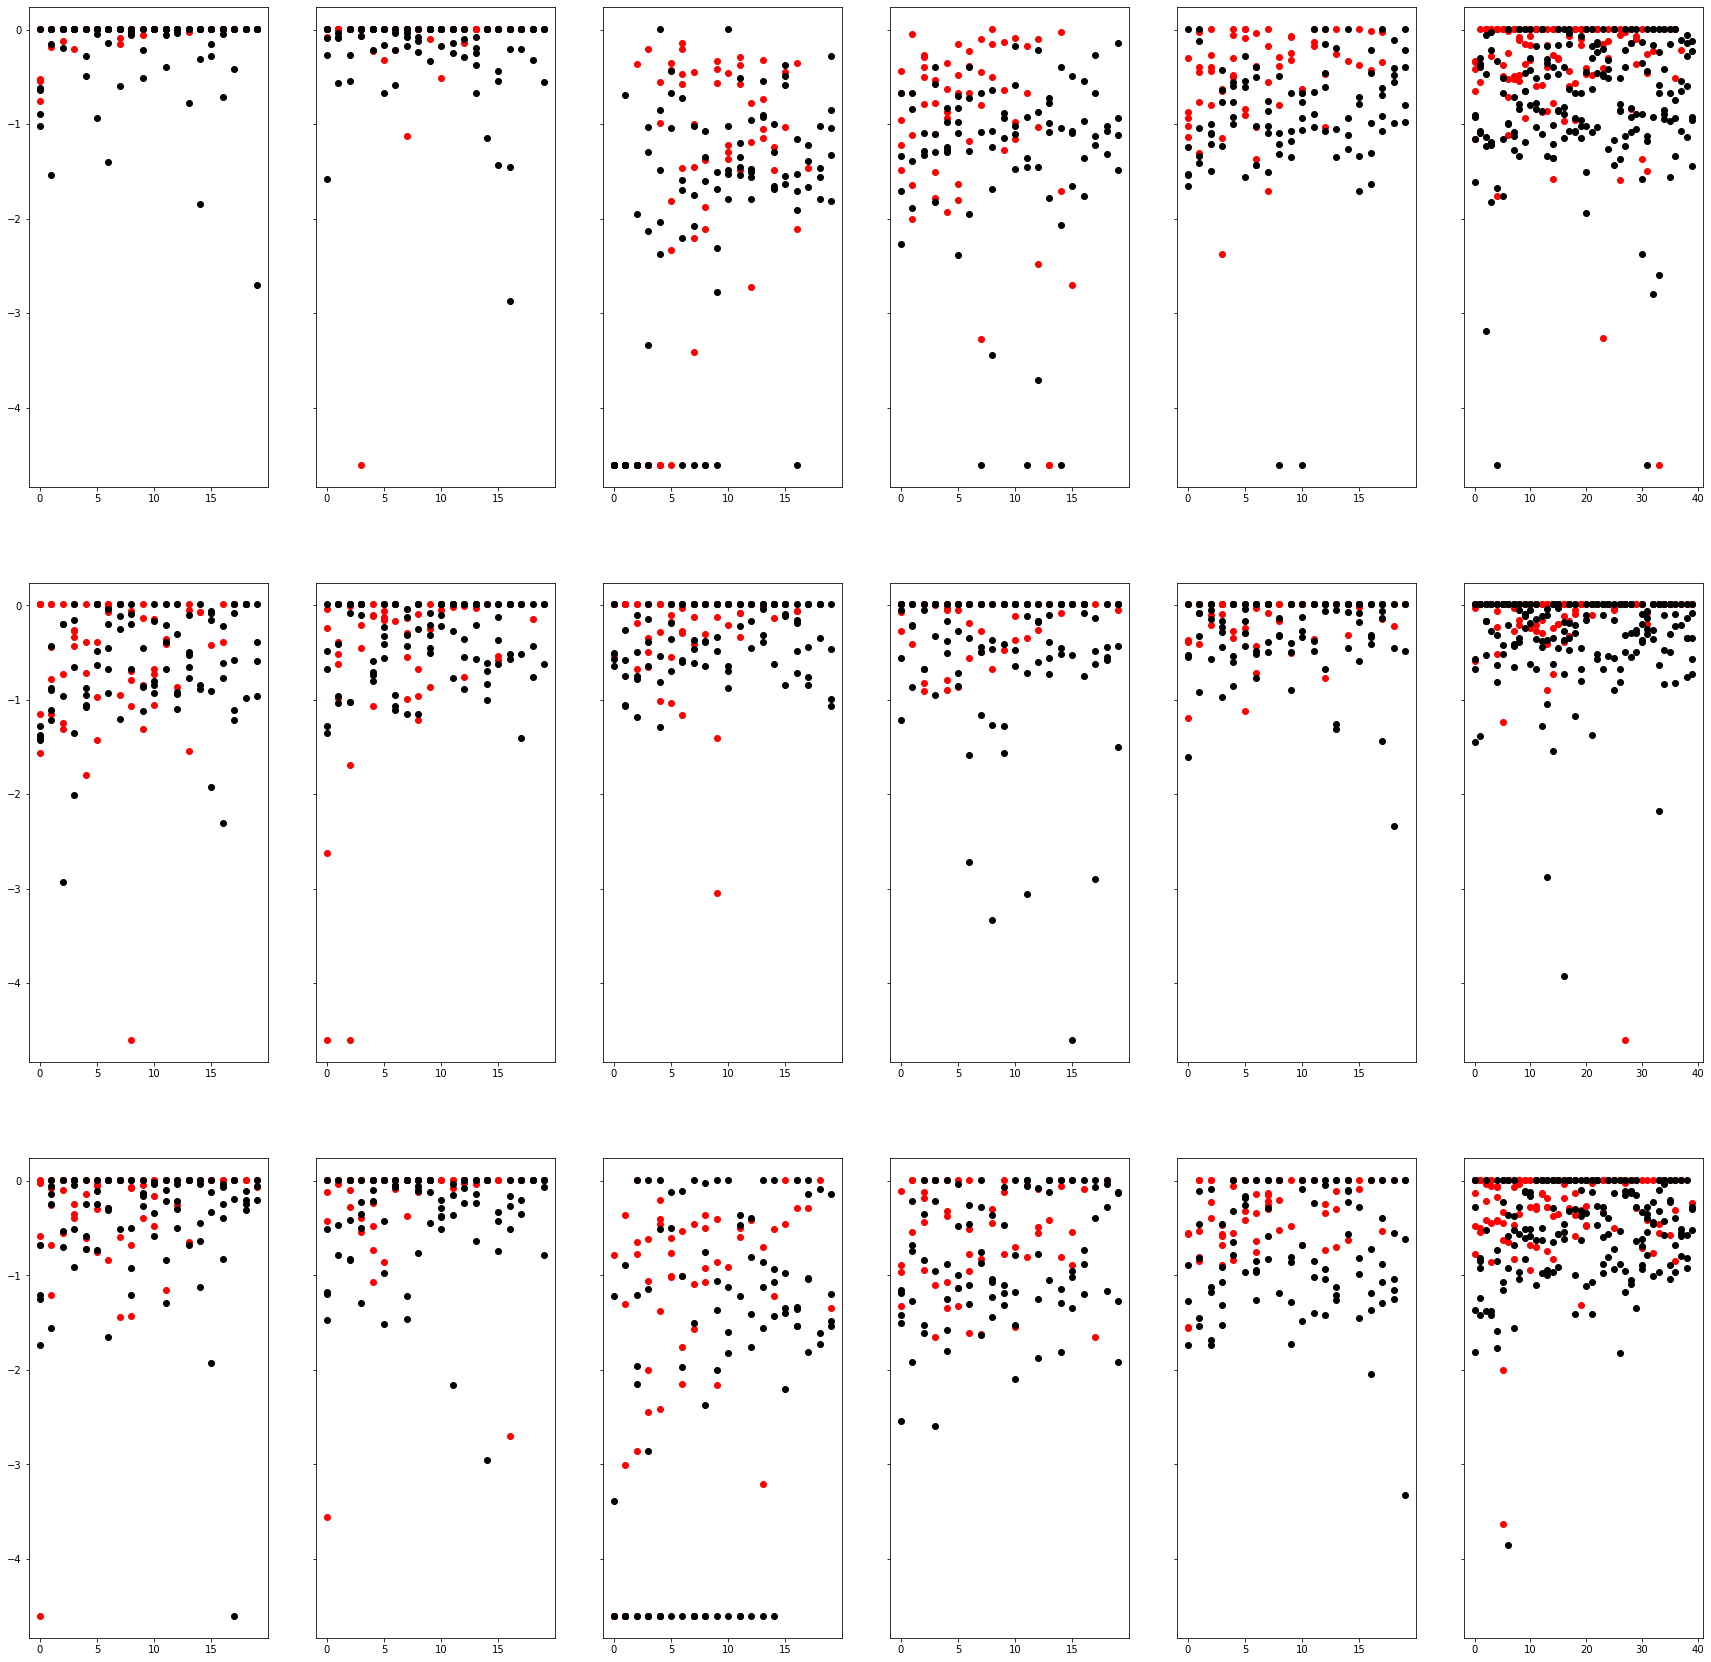

In [23]:
fig,ax = plt.subplots(3,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,3,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
#             block_mask = (d['block_number']==block)*(d['LR']==-1)
            block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = np.log(d['lick_acc'][block_mask]+1E-2)
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmedian(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            
#             block_mask = (d['block_number']==block)*(d['LR']==-1)
            block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = np.log(d['lick_acc'][block_mask]+1E-2)
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmedian(lick_varpos[probes==0])

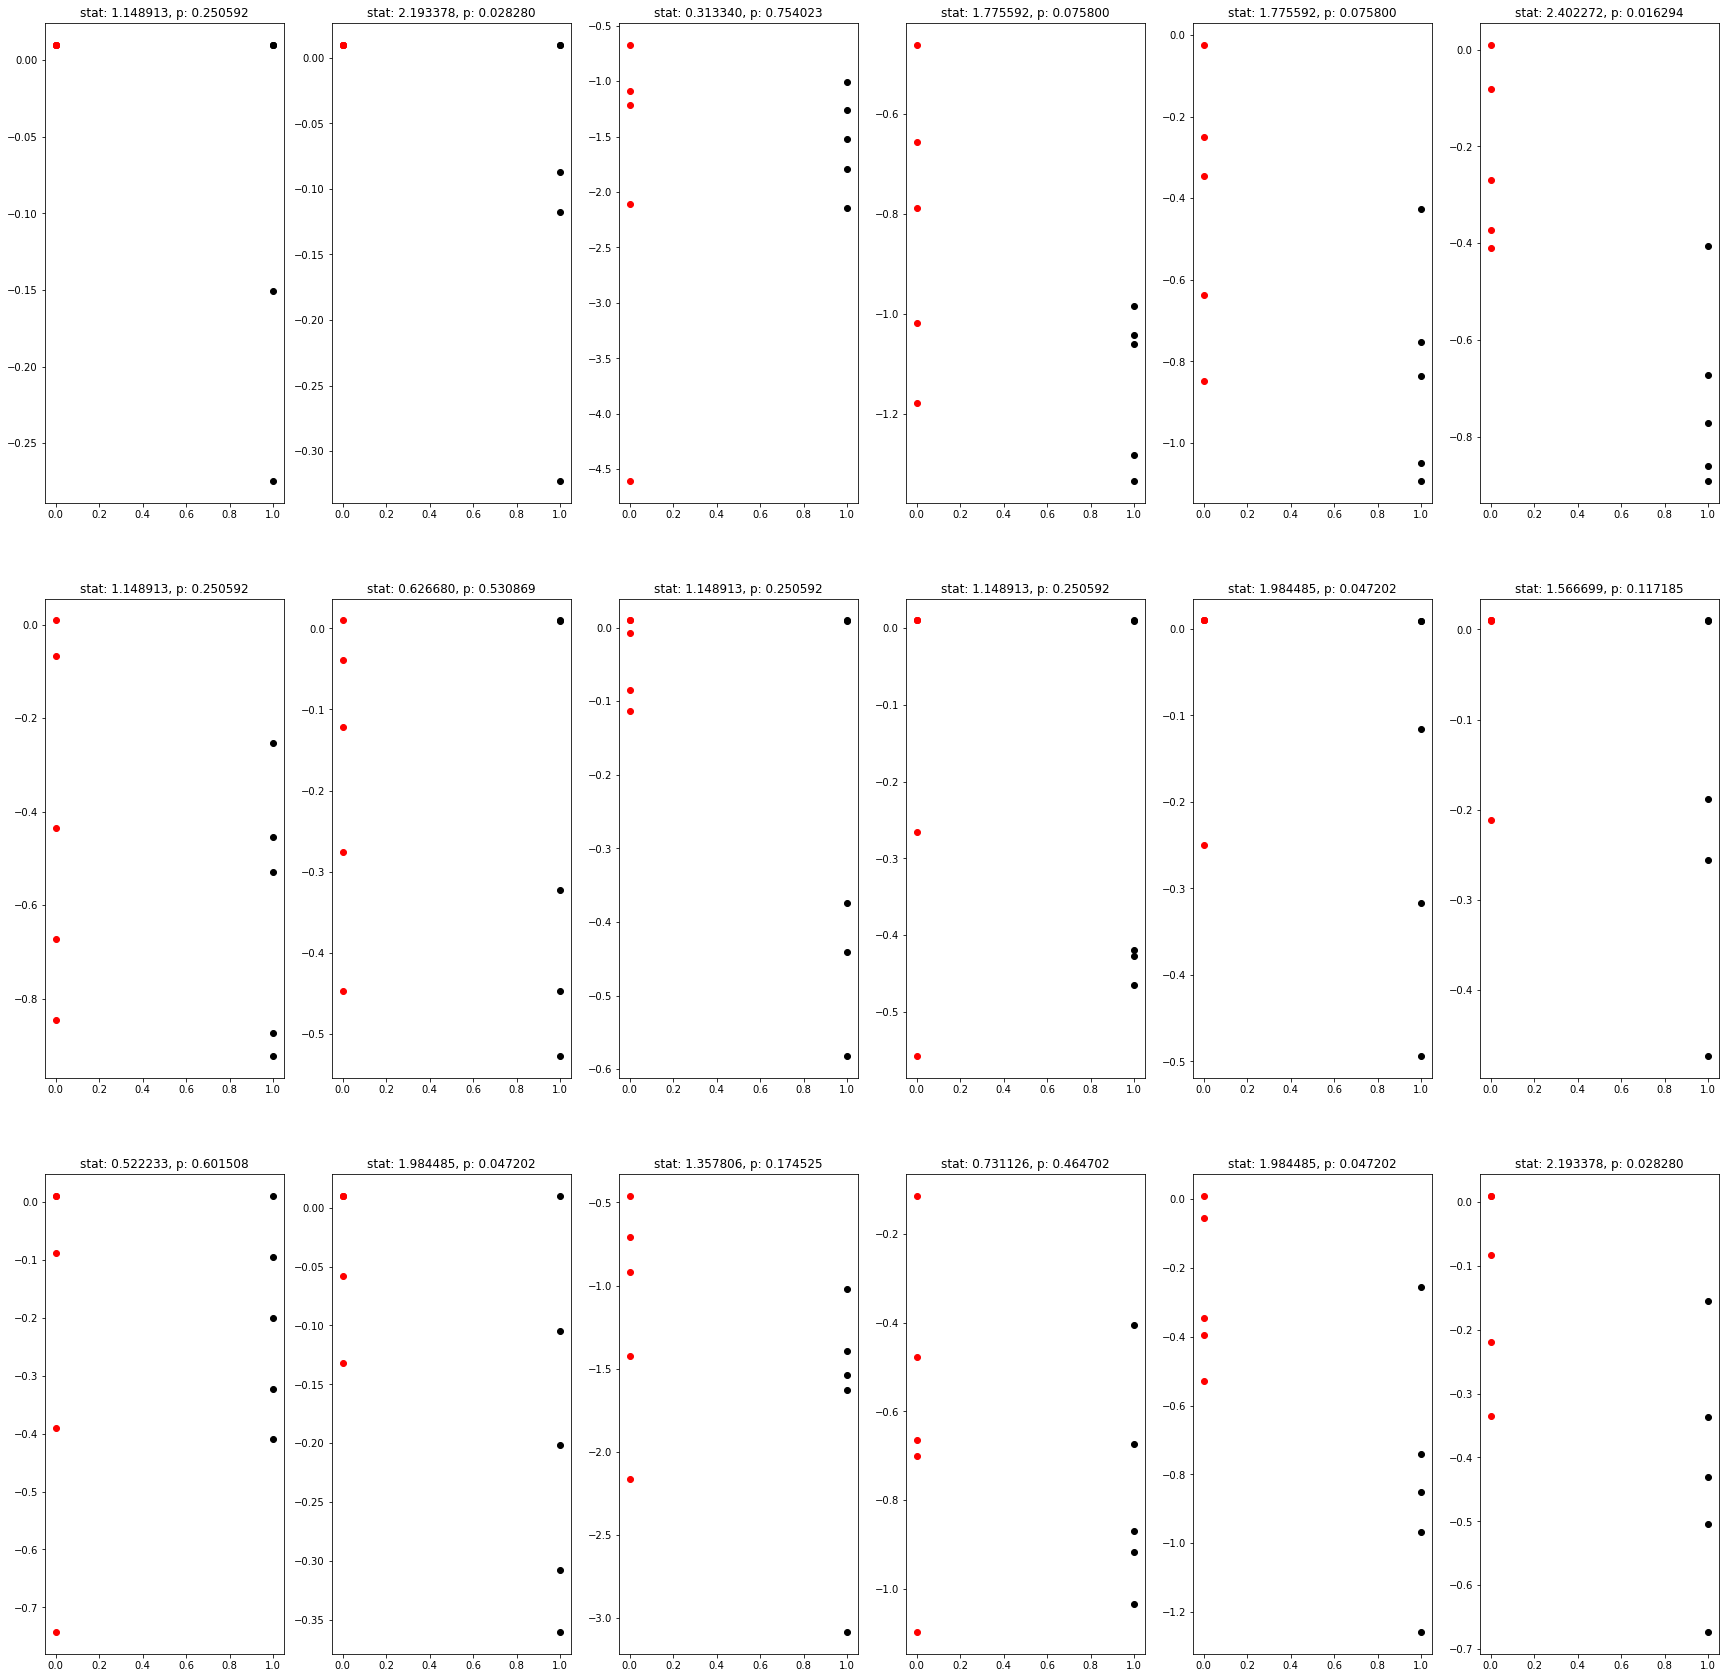

In [24]:
fig,ax = plt.subplots(3,6,figsize=[30,30])

for row in range(3):
    for col in range(6):
        ax[row,col].scatter(np.zeros([5,]), KO_vars[:,row,col],color='red')
        ax[row,col].scatter(np.ones([5,]), CTRL_vars[:,row,col],color='black')
        stat,p = sp.stats.ranksums(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
#         stat,p = sp.stats.ttest_ind(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        ax[row,col].set_title("stat: %f, p: %f" % (stat,p))

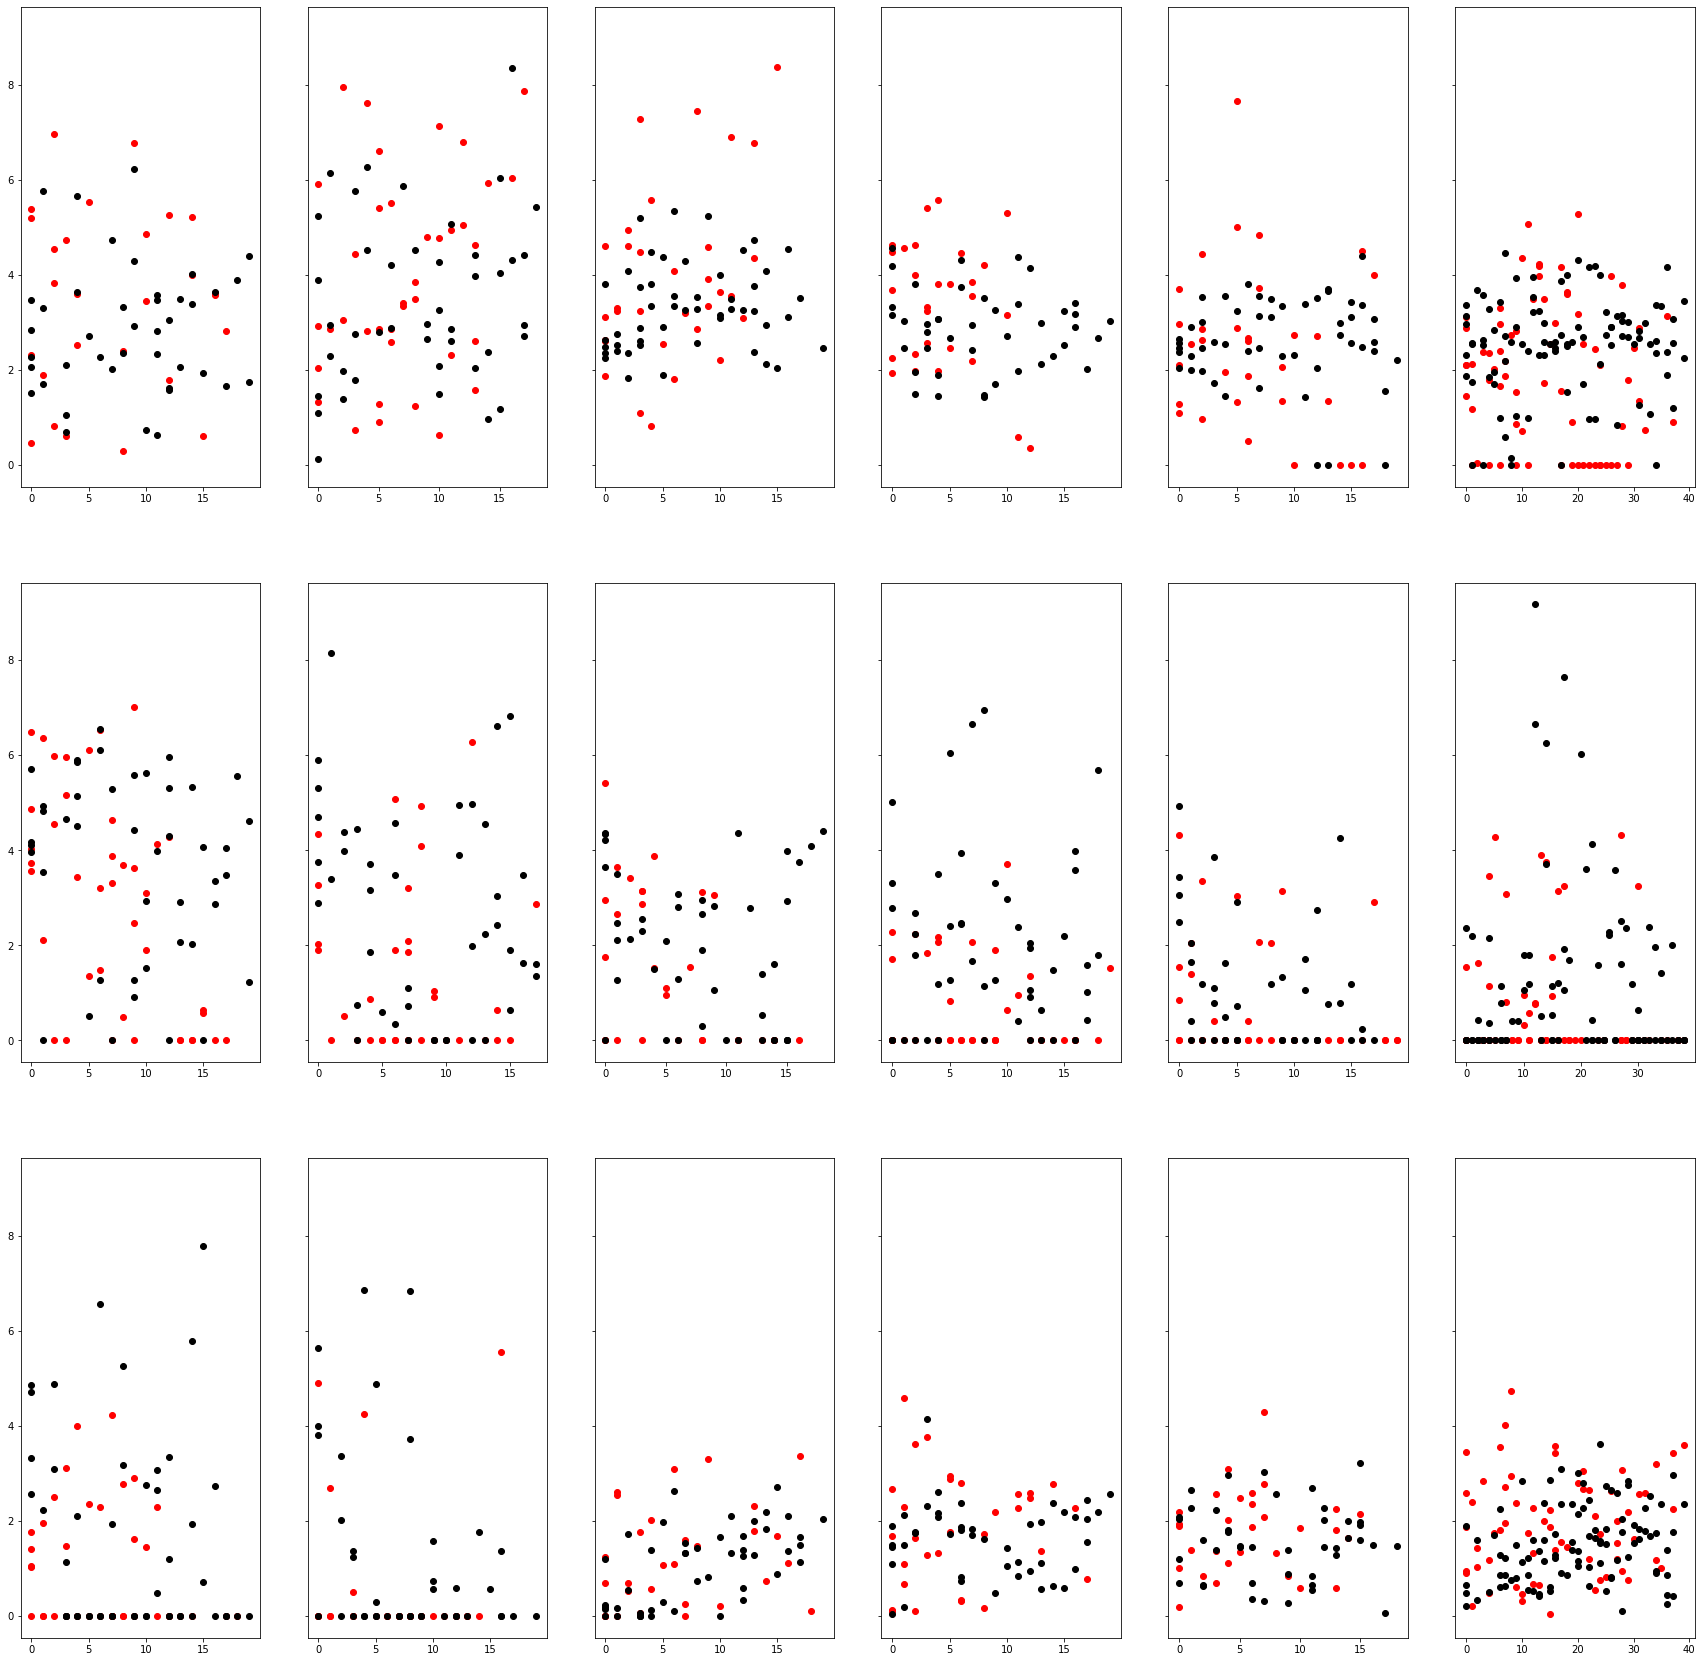

In [25]:
fig,ax = plt.subplots(3,6,figsize=[30,30], sharey=True)

KO_vars = np.zeros([5,3,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            block_mask = (d['block_number']==block)*(d['LR']==-1)
#             block_mask = d['block_number']==block
            
            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]
            
            lick_varpos = d['lickrate_rz_early'][block_mask]
            probes = d['probes'][block_mask]
            
            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'red')
            
            
            KO_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

CTRL_vars = np.zeros([5,6,6])
for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[-3:]):
        
#         _block_trial_start = 0
        for block in range(6):
            
            block_mask = (d['block_number']==block)*(d['LR']==-1)
#             block_mask = d['block_number']==block

            trial_num = d['trial_number'][block_mask]
            trial_num = trial_num-trial_num[0]

            lick_varpos = d['lickrate_rz_early'][block_mask]
            probes = d['probes'][block_mask]

            ax[j,block].scatter(trial_num[probes==0],lick_varpos[probes==0], color = 'black')
           
            
            CTRL_vars[i,j,block] = np.nanmean(lick_varpos[probes==0])

In [41]:
def concat_lickrate(d_list):
    lr_rz_early_norm = []
    lr_rz_late_norm = []
    for j,d in enumerate(d_list):
        if j == 0:
            baseline_early_inds = (d['block_number']<2)*(d['LR']==-1)
            baseline_late_inds = (d['block_number']<2)*(d['LR']==1)
            baseline_early = d['lickrate_rz_early'][baseline_early_inds].mean()
            baseline_late = d['lickrate_rz_late'][baseline_late_inds].mean()


            nonbaseline_inds = d['block_number']>=2
            lr_rz_early_norm.append(d['lickrate_rz_early'][nonbaseline_inds*(d['LR']==-1)]/baseline_early)
            lr_rz_late_norm.append(d['lickrate_rz_late'][nonbaseline_inds*(d['LR']==1)]/baseline_late)

        elif j ==1 :    
            nonbaseline_inds = d['LR']==-1
            lr_rz_early_norm.append(d['lickrate_rz_early'][d['LR']==-1]/baseline_early)
            lr_rz_late_norm.append(d['lickrate_rz_late'][d['LR']==1]/baseline_late)
        else:
            nonbaseline_inds = d['block_number']<2
            lr_rz_early_norm.append(d['lickrate_rz_early'][nonbaseline_inds*(d['LR']==-1)]/baseline_early)
            lr_rz_late_norm.append(d['lickrate_rz_late'][nonbaseline_inds*(d['LR']==1)]/baseline_late)

    lr_rz_early_norm = np.concatenate(lr_rz_early_norm)
    lr_rz_late_norm = np.concatenate(lr_rz_late_norm)

    inds_early = np.arange(lr_rz_early_norm.shape[0])
    inds_late = np.arange(lr_rz_late_norm.shape[0])
        
        
    return {'early_rz_inds': inds_early, 'early_rz_lr': lr_rz_early_norm, 'late_rz_inds':inds_late, 'late_rz_lr': lr_rz_late_norm}

def generate_perms(mouse_list0,mouse_list1):
    
    allmice = mouse_list0 +mouse_list1
    perms = []
    for l0 in combinations(allmice,5):
        if not (set(l0)==set(mouse_list0) or set(l0)==set(mouse_list1)):
            l1 = [m for  m in allmice if m not in l0]
            perms.append((l0,l1))
    return perms

def _concat_dicts(d, keys):
    out_d = {}
    for key in keys:
        
        out_d[key] = np.concatenate([val[key] for mouse,val in d.items()])
    return out_d


def run_reversal_lrs(KO_sessions,CTRL_sessions):
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]

    KO_reversal_lrs={mouse:concat_lickrate(d_list[-3:]) for mouse,d_list in KO_sessions.items()}
    KO_concat_lrs = _concat_dicts(KO_reversal_lrs,['early_rz_inds', 'early_rz_lr', 'late_rz_inds', 'late_rz_lr'])
    
    CTRL_reversal_lrs={mouse:concat_lickrate(d_list[-3:]) for mouse,d_list in CTRL_sessions.items()}
    CTRL_concat_lrs = _concat_dicts(CTRL_reversal_lrs,['early_rz_inds', 'early_rz_lr', 'late_rz_inds', 'late_rz_lr'])
    
    all_reversal_lrs = {**KO_reversal_lrs, **CTRL_reversal_lrs}
    
    KO_early_popt, KO_early_pcov = curve_fit(monoexp_decay, KO_concat_lrs['early_rz_inds'], KO_concat_lrs['early_rz_lr'], maxfev=int(1E5),method='trf', loss='linear')
    CTRL_early_popt, CTRL_early_pcov = curve_fit(monoexp_decay, CTRL_concat_lrs['early_rz_inds'], CTRL_concat_lrs['early_rz_lr'], maxfev=int(1E5),method='trf', loss='linear')
    
    early_true_diff = np.abs(KO_early_popt-CTRL_early_popt)
    
    KO_late_popt, KO_late_pcov = curve_fit(monoexp_decay, KO_concat_lrs['late_rz_inds'], KO_concat_lrs['late_rz_lr'], maxfev=int(1E5),method='trf', loss='linear')
    CTRL_late_popt, CTRL_late_pcov = curve_fit(monoexp_decay, CTRL_concat_lrs['late_rz_inds'], CTRL_concat_lrs['late_rz_lr'], maxfev=int(1E5),method='trf', loss='linear')
    
    late_true_diff = np.abs(KO_late_popt - CTRL_late_popt)
    
    
    perms = generate_perms(ko_mice,ctrl_mice)
    
    early_perm_diff, late_perm_diff = [], []
    print(all_reversal_lrs.keys())
    for (l0,l1) in perms:
        l0_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l0},['early_rz_inds', 'early_rz_lr', 'late_rz_inds', 'late_rz_lr'])
        l1_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l1},['early_rz_inds', 'early_rz_lr', 'late_rz_inds', 'late_rz_lr'])
        
    
    
        l0_early_popt, l0_early_pcov = curve_fit(monoexp_decay, l0_concat_lrs['early_rz_inds'], l0_concat_lrs['early_rz_lr'], maxfev=int(1E5),method='trf', loss='linear')
        l1_early_popt, l1_early_pcov = curve_fit(monoexp_decay, l1_concat_lrs['early_rz_inds'], l1_concat_lrs['early_rz_lr'], maxfev=int(1E5),method='trf', loss='linear')
    
        early_perm_diff.append(np.abs(l0_early_popt-l1_early_popt))
    
        l0_late_popt, l0_late_pcov = curve_fit(monoexp_decay, l0_concat_lrs['late_rz_inds'], l0_concat_lrs['late_rz_lr'], maxfev=int(1E5),method='trf', loss='linear')
        l1_late_popt, l1_late_pcov = curve_fit(monoexp_decay, l1_concat_lrs['late_rz_inds'], l1_concat_lrs['late_rz_lr'], maxfev=int(1E5),method='trf', loss='linear')
    
        late_perm_diff.append(np.abs(l0_late_popt - l1_early_popt))
        
    early_perm_diff = np.array(early_perm_diff)
    late_perm_diff = np.array(late_perm_diff)
    print('Left values', KO_early_popt, CTRL_early_popt)
    print('p-values', [1-np.float((early_true_diff[i]>=early_perm_diff[:,i]).sum())/early_perm_diff.shape[0] for i in range(3)])
    
    print('Right values', KO_late_popt, CTRL_late_popt)
    print('p-values', [1-np.float((late_true_diff[i]>=late_perm_diff[:,i]).sum())/late_perm_diff.shape[0] for i in range(3)])
    
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter(KO_concat_lrs['early_rz_inds'],KO_concat_lrs['early_rz_lr'],color='red',alpha=.3)
    ax[0].scatter(CTRL_concat_lrs['early_rz_inds'],CTRL_concat_lrs['early_rz_lr'],color='black',alpha=.3)

    t = np.linspace(0,140)
    
    ax[0].plot(t, monoexp_decay(t, *KO_early_popt), color='red',linewidth=5)
    ax[0].plot(t, monoexp_decay(t, *CTRL_early_popt), color='black',linewidth=5)
    
    
    ax[1].scatter(KO_concat_lrs['late_rz_inds'],KO_concat_lrs['late_rz_lr'],color='red',alpha=.3)
    ax[1].scatter(CTRL_concat_lrs['late_rz_inds'],CTRL_concat_lrs['late_rz_lr'],color='black',alpha=.3)
    
    ax[1].plot(t, monoexp_decay(t, *KO_late_popt), color='red',linewidth=5)
    ax[1].plot(t, monoexp_decay(t, *CTRL_late_popt), color='black',linewidth=5)
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    ax[0].set_ylabel('Lick Rate (norm.)')
    ax[0].set_xlabel('Repetition/Trial')
    fig.suptitle('Previous Reward Zone Licking')
    ax[0].set_title('Left Trials')
    
    ax[1].set_xlabel('Repetition/Trial')
    ax[1].set_ylabel('Lick Rate(norm)')
    ax[1].set_title('Right Trials')
    
    



run_reversal_lrs(KO_sessions,CTRL_sessions)
    
    
    
    



dict_keys(['4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', '4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1'])
Left values [0.97363375 0.02282006] [0.9057104  0.00680947]


IndexError: index 2 is out of bounds for axis 0 with size 2

[-0.03006994  0.01655994  0.12848688]
dict_keys(['4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', '4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1'])
[-0.03006994  0.01655994  0.12848688] [ 0.00186192  0.00965912 -0.025422  ]
(250, 3) (250, 3)
Left values [ 1.56881662  0.02543668 -0.99808937] [ 1.61535119  0.06122041 -0.68148573]
p-values [0.532, 0.09199999999999997, 0.32399999999999995]
Right values [ 1.61721311  0.07087953 -0.70690773] [ 1.61535119  0.06122041 -0.68148573]
p-values [0.488, 0.396, 0.5640000000000001]


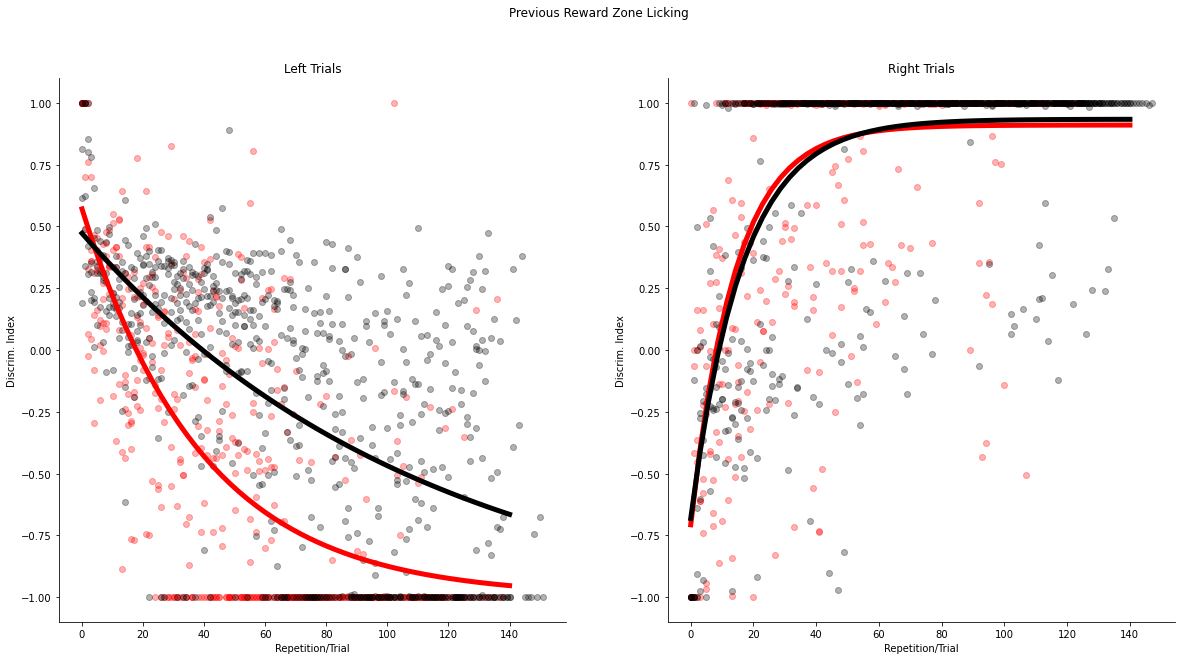

In [31]:
def concat_discrim(d_list):
    lr_discrim_left = []
    lr_discrim_right = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:    
            nonbaseline_inds = d['block_number']>=2
            lr_discrim_left.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_discrim_right.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_discrim_left.append(d['lickrate_dprime'][(d['LR']==-1)])
            lr_discrim_right.append(d['lickrate_dprime'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_discrim_left.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_discrim_right.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
            
    lr_discrim_left = np.concatenate(lr_discrim_left)
    lr_discrim_right = np.concatenate(lr_discrim_right)

    inds_left = np.arange(lr_discrim_left.shape[0])
    inds_right = np.arange(lr_discrim_right.shape[0])
        
        
    return {'left_inds': inds_left, 'left_discrim': lr_discrim_left, 'right_inds':inds_right, 'right_discrim': lr_discrim_right}




def run_reversal_discrim(KO_sessions,CTRL_sessions):
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]

    KO_reversal_lrs={mouse:concat_discrim(d_list[-3:]) for mouse,d_list in KO_sessions.items()}
    KO_concat_lrs = _concat_dicts(KO_reversal_lrs,['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
    
    CTRL_reversal_lrs={mouse:concat_discrim(d_list[-3:]) for mouse,d_list in CTRL_sessions.items()}
    CTRL_concat_lrs = _concat_dicts(CTRL_reversal_lrs,['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
    
    all_reversal_lrs = {**KO_reversal_lrs, **CTRL_reversal_lrs}
    
    KO_left_popt, KO_left_pcov = curve_fit(monoexp_decay_wint, KO_concat_lrs['left_inds'], KO_concat_lrs['left_discrim'], maxfev=int(1E5),method='trf', loss='huber')
    CTRL_left_popt, CTRL_left_pcov = curve_fit(monoexp_decay_wint, CTRL_concat_lrs['left_inds'], CTRL_concat_lrs['left_discrim'], maxfev=int(1E5),method='trf', loss='huber')
    
    left_true_diff = KO_left_popt-CTRL_left_popt
    print(left_true_diff)
    
    KO_right_popt, KO_right_pcov = curve_fit(monoexp_growth_wint, KO_concat_lrs['right_inds'], KO_concat_lrs['right_discrim'], maxfev=int(1E5),method='trf', loss='huber')
    CTRL_right_popt, CTRL_right_pcov = curve_fit(monoexp_growth_wint, CTRL_concat_lrs['right_inds'], CTRL_concat_lrs['right_discrim'], maxfev=int(1E5),method='trf', loss='huber')
    
    right_true_diff = KO_right_popt - CTRL_right_popt
    
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter(KO_concat_lrs['left_inds'],KO_concat_lrs['left_discrim'],color='red',alpha=.3)
    ax[0].scatter(CTRL_concat_lrs['left_inds'],CTRL_concat_lrs['left_discrim'],color='black',alpha=.3)

    ax[1].scatter(KO_concat_lrs['right_inds'],KO_concat_lrs['right_discrim'],color='red',alpha=.3)
    ax[1].scatter(CTRL_concat_lrs['right_inds'],CTRL_concat_lrs['right_discrim'],color='black',alpha=.3)
    
    perms = generate_perms(ko_mice,ctrl_mice)
    
    left_perm_diff, right_perm_diff = [], []
    print(all_reversal_lrs.keys())
    for (l0,l1) in perms:
        l0_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l0},['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
        l1_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l1},['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
        
    
    
        l0_left_popt, l0_left_pcov = curve_fit(monoexp_decay_wint, l0_concat_lrs['left_inds'], l0_concat_lrs['left_discrim'], maxfev=int(1E5),method='trf', loss='huber')
        l1_left_popt, l1_left_pcov = curve_fit(monoexp_decay_wint, l1_concat_lrs['left_inds'], l1_concat_lrs['left_discrim'], maxfev=int(1E5),method='trf', loss='huber')
    
        left_perm_diff.append(l0_left_popt-l1_left_popt)
    
        l0_right_popt, l0_right_pcov = curve_fit(monoexp_growth_wint, l0_concat_lrs['right_inds'], l0_concat_lrs['right_discrim'], maxfev=int(1E5),method='trf', loss='huber')
        l1_right_popt, l1_right_pcov = curve_fit(monoexp_growth_wint, l1_concat_lrs['right_inds'], l1_concat_lrs['right_discrim'], maxfev=int(1E5),method='trf', loss='huber')
    
        right_perm_diff.append(l0_right_popt - l1_right_popt)
        
    left_perm_diff = np.array(left_perm_diff)
    right_perm_diff = np.array(right_perm_diff)
    
    print(left_true_diff, right_true_diff)
    print(left_perm_diff.shape, right_perm_diff.shape)
    print('Left values', KO_left_popt, CTRL_right_popt)
    print('p-values', [1-np.float((left_true_diff[i]>=left_perm_diff[:,i]).sum())/left_perm_diff.shape[0] for i in range(3)])
    
    print('Right values', KO_right_popt, CTRL_right_popt)
    print('p-values', [1-np.float((right_true_diff[i]>=right_perm_diff[:,i]).sum())/right_perm_diff.shape[0] for i in range(3)])
    
    
    t = np.linspace(0,140)
    
    ax[0].plot(t, monoexp_decay_wint(t, *KO_left_popt), color='red',linewidth=5)
    ax[0].plot(t, monoexp_decay_wint(t, *CTRL_left_popt), color='black',linewidth=5)
    
    
    
    
    ax[1].plot(t, monoexp_growth_wint(t, *KO_right_popt), color='red',linewidth=5)
    ax[1].plot(t, monoexp_growth_wint(t, *CTRL_right_popt), color='black',linewidth=5)
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    ax[0].set_ylabel('Discrim. Index')
    ax[0].set_xlabel('Repetition/Trial')
    fig.suptitle('Previous Reward Zone Licking')
    ax[0].set_title('Left Trials')
    
    ax[1].set_xlabel('Repetition/Trial')
    ax[1].set_ylabel('Discrim. Index')
    ax[1].set_title('Right Trials')
    
    



run_reversal_discrim(KO_sessions,CTRL_sessions)
    
    
    

[0.16546672 0.02201074]
dict_keys(['4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', '4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1'])
[0.16546672 0.02201074] [0.03926833 0.06568472]
(250, 2) (250, 2)
Left values [0.87470684 0.04728531] [0.85205153 0.04437182]
p-values [0.09599999999999997, 0.19999999999999996]
Right values [0.89131986 0.11005653] [0.85205153 0.04437182]
p-values [0.19199999999999995, 0.008000000000000007]


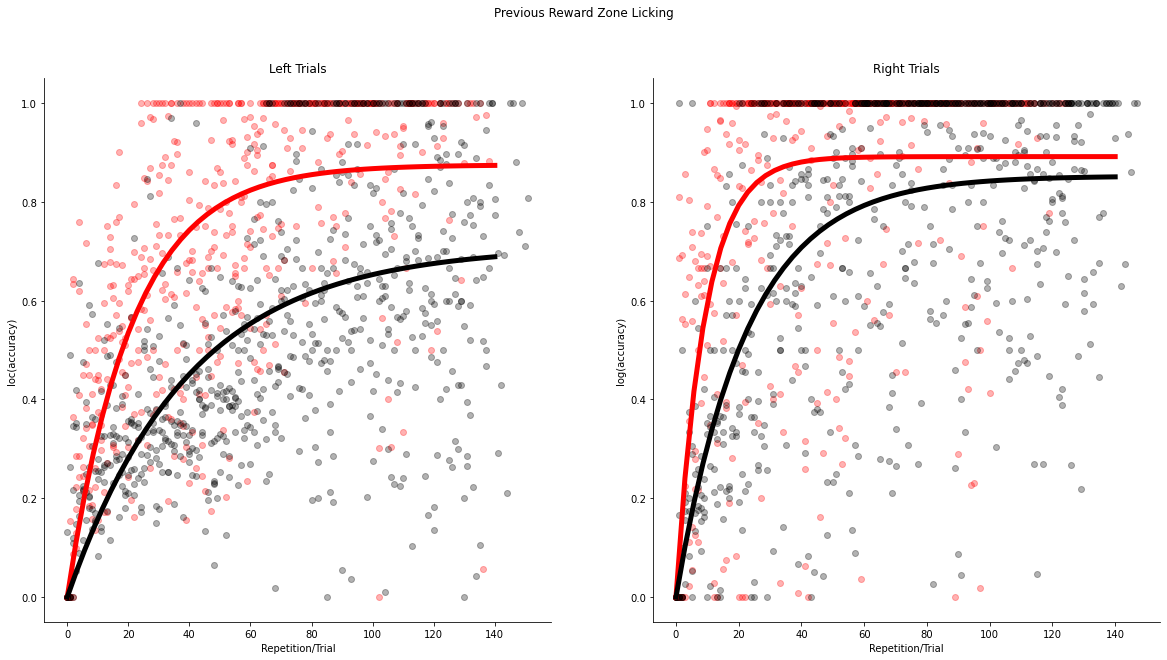

In [38]:
def concat_acc(d_list):
    lr_acc_left = []
    lr_acc_right = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:    
            nonbaseline_inds = d['block_number']>=2
            lr_acc_left.append(d['lick_acc'][nonbaseline_inds*(d['LR']==-1)])
            lr_acc_right.append(d['lick_acc'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_acc_left.append(d['lick_acc'][(d['LR']==-1)])
            lr_acc_right.append(d['lick_acc'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_acc_left.append(d['lick_acc'][nonbaseline_inds*(d['LR']==-1)])
            lr_acc_right.append(d['lick_acc'][nonbaseline_inds*(d['LR']==1)])
            
    lr_acc_left = np.concatenate(lr_acc_left)
    lr_acc_right = np.concatenate(lr_acc_right)

    inds_left = np.arange(lr_acc_left.shape[0])
    inds_right = np.arange(lr_acc_right.shape[0])
        
        
    return {'left_inds': inds_left, 'left_acc': lr_acc_left, 'right_inds':inds_right, 'right_acc': lr_acc_right}

def monoexp_rise(x,a,b):
    return a*(1-np.exp(-b*x)) 


def run_reversal_acc(KO_sessions,CTRL_sessions):
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]

    KO_reversal_lrs={mouse:concat_acc(d_list[-3:]) for mouse,d_list in KO_sessions.items()}
    KO_concat_lrs = _concat_dicts(KO_reversal_lrs,['left_inds', 'left_acc', 'right_inds', 'right_acc'])
    
    CTRL_reversal_lrs={mouse:concat_acc(d_list[-3:]) for mouse,d_list in CTRL_sessions.items()}
    CTRL_concat_lrs = _concat_dicts(CTRL_reversal_lrs,['left_inds', 'left_acc', 'right_inds', 'right_acc'])
    
    all_reversal_lrs = {**KO_reversal_lrs, **CTRL_reversal_lrs}
    
    KO_left_popt, KO_left_pcov = curve_fit(monoexp_rise, KO_concat_lrs['left_inds'], KO_concat_lrs['left_acc'], maxfev=int(1E5),method='trf', loss='linear')
    CTRL_left_popt, CTRL_left_pcov = curve_fit(monoexp_rise, CTRL_concat_lrs['left_inds'], CTRL_concat_lrs['left_acc'], maxfev=int(1E5),method='trf', loss='linear')
    
    left_true_diff = KO_left_popt-CTRL_left_popt
    print(left_true_diff)
    
    KO_right_popt, KO_right_pcov = curve_fit(monoexp_rise, KO_concat_lrs['right_inds'], KO_concat_lrs['right_acc'], maxfev=int(1E5),method='trf', loss='linear')
    CTRL_right_popt, CTRL_right_pcov = curve_fit(monoexp_rise, CTRL_concat_lrs['right_inds'], CTRL_concat_lrs['right_acc'], maxfev=int(1E5),method='trf', loss='linear')
    
    right_true_diff = KO_right_popt - CTRL_right_popt
    
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter(KO_concat_lrs['left_inds'],KO_concat_lrs['left_acc'],color='red',alpha=.3)
    ax[0].scatter(CTRL_concat_lrs['left_inds'],CTRL_concat_lrs['left_acc'],color='black',alpha=.3)

    ax[1].scatter(KO_concat_lrs['right_inds'],KO_concat_lrs['right_acc'],color='red',alpha=.3)
    ax[1].scatter(CTRL_concat_lrs['right_inds'],CTRL_concat_lrs['right_acc'],color='black',alpha=.3)
    
    perms = generate_perms(ko_mice,ctrl_mice)
    
    left_perm_diff, right_perm_diff = [], []
    print(all_reversal_lrs.keys())
    for (l0,l1) in perms:
        l0_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l0},['left_inds', 'left_acc', 'right_inds', 'right_acc'])
        l1_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l1},['left_inds', 'left_acc', 'right_inds', 'right_acc'])
        
    
    
        l0_left_popt, l0_left_pcov = curve_fit(monoexp_rise, l0_concat_lrs['left_inds'], l0_concat_lrs['left_acc'], maxfev=int(1E5),method='trf', loss='linear')
        l1_left_popt, l1_left_pcov = curve_fit(monoexp_rise, l1_concat_lrs['left_inds'], l1_concat_lrs['left_acc'], maxfev=int(1E5),method='trf', loss='linear')
    
        left_perm_diff.append(l0_left_popt-l1_left_popt)
    
        l0_right_popt, l0_right_pcov = curve_fit(monoexp_rise, l0_concat_lrs['right_inds'], l0_concat_lrs['right_acc'], maxfev=int(1E5),method='trf', loss='linear')
        l1_right_popt, l1_right_pcov = curve_fit(monoexp_rise, l1_concat_lrs['right_inds'], l1_concat_lrs['right_acc'], maxfev=int(1E5),method='trf', loss='linear')
    
        right_perm_diff.append(l0_right_popt - l1_right_popt)
        
    left_perm_diff = np.array(left_perm_diff)
    right_perm_diff = np.array(right_perm_diff)
    
    print(left_true_diff, right_true_diff)
    print(left_perm_diff.shape, right_perm_diff.shape)
    print('Left values', KO_left_popt, CTRL_right_popt)
    print('p-values', [1-np.float((left_true_diff[i]>=left_perm_diff[:,i]).sum())/left_perm_diff.shape[0] for i in range(2)])
    
    print('Right values', KO_right_popt, CTRL_right_popt)
    print('p-values', [1-np.float((right_true_diff[i]>=right_perm_diff[:,i]).sum())/right_perm_diff.shape[0] for i in range(2)])
    
    
    t = np.linspace(0,140)
    
    ax[0].plot(t, monoexp_rise(t, *KO_left_popt), color='red',linewidth=5)
    ax[0].plot(t, monoexp_rise(t, *CTRL_left_popt), color='black',linewidth=5)
    
    
    
    
    ax[1].plot(t, monoexp_rise(t, *KO_right_popt), color='red',linewidth=5)
    ax[1].plot(t, monoexp_rise(t, *CTRL_right_popt), color='black',linewidth=5)
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    ax[0].set_ylabel('loc(accuracy)')
    ax[0].set_xlabel('Repetition/Trial')
    fig.suptitle('Previous Reward Zone Licking')
    ax[0].set_title('Left Trials')
    
    ax[1].set_xlabel('Repetition/Trial')
    ax[1].set_ylabel('log(accuracy)')
    ax[1].set_title('Right Trials')
    
    



run_reversal_acc(KO_sessions,CTRL_sessions)
    
    

In [ ]:
# omission rate

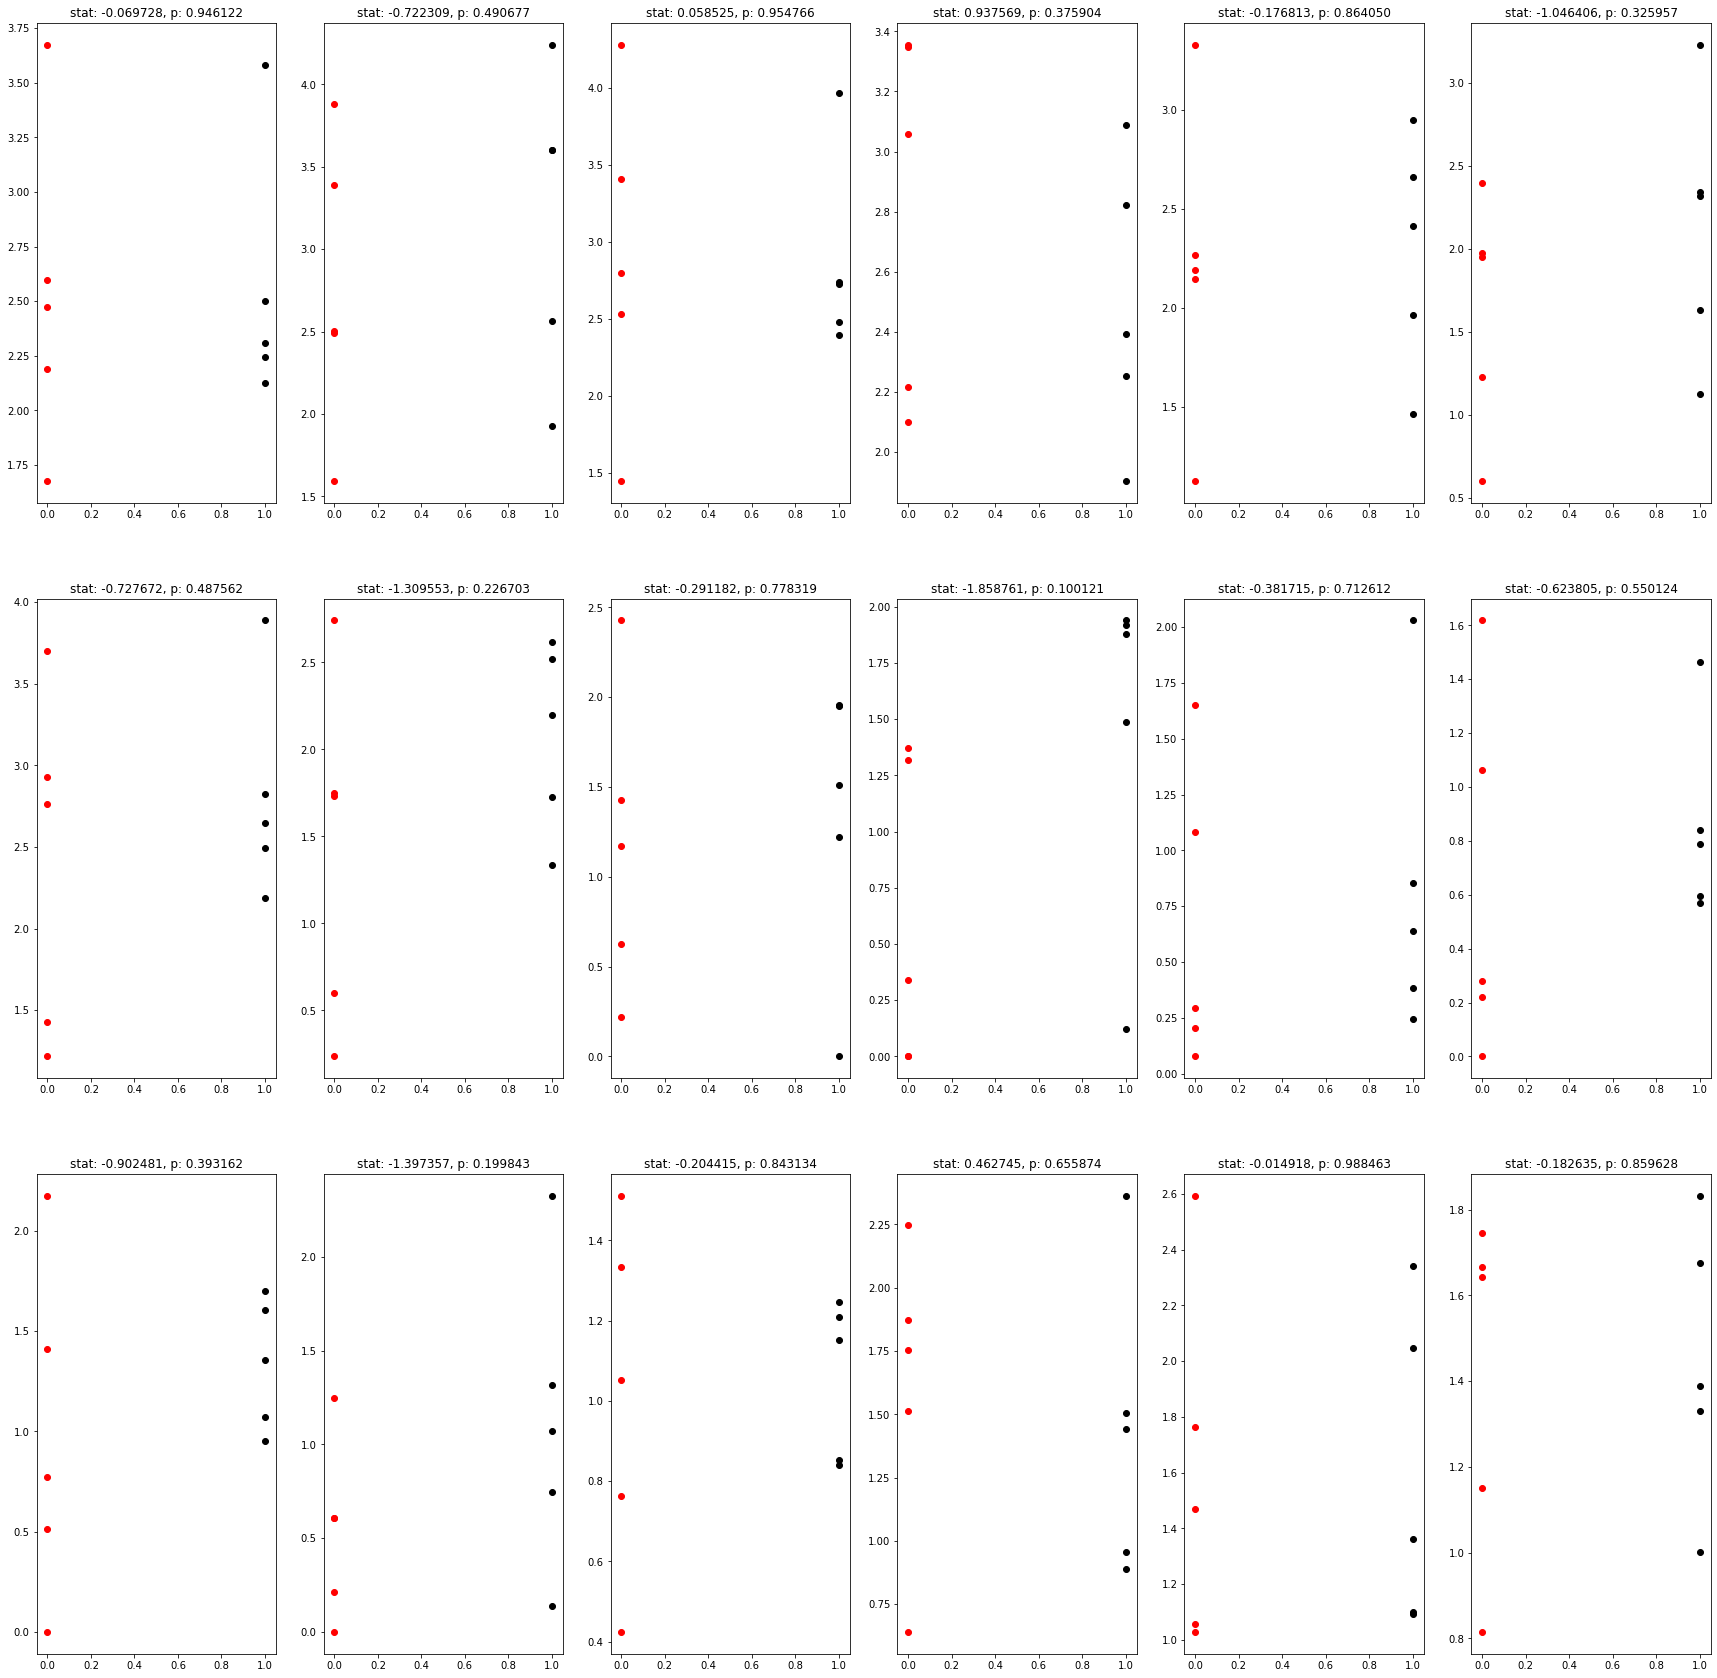

In [31]:
fig,ax = plt.subplots(3,6,figsize=[30,30])

for row in range(3):
    for col in range(6):
        ax[row,col].scatter(np.zeros([5,]), KO_vars[:,row,col],color='red')
        ax[row,col].scatter(np.ones([5,]), CTRL_vars[:,row,col],color='black')
#         stat,p = sp.stats.ranksums(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        stat,p = sp.stats.ttest_ind(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        ax[row,col].set_title("stat: %f, p: %f" % (stat,p))

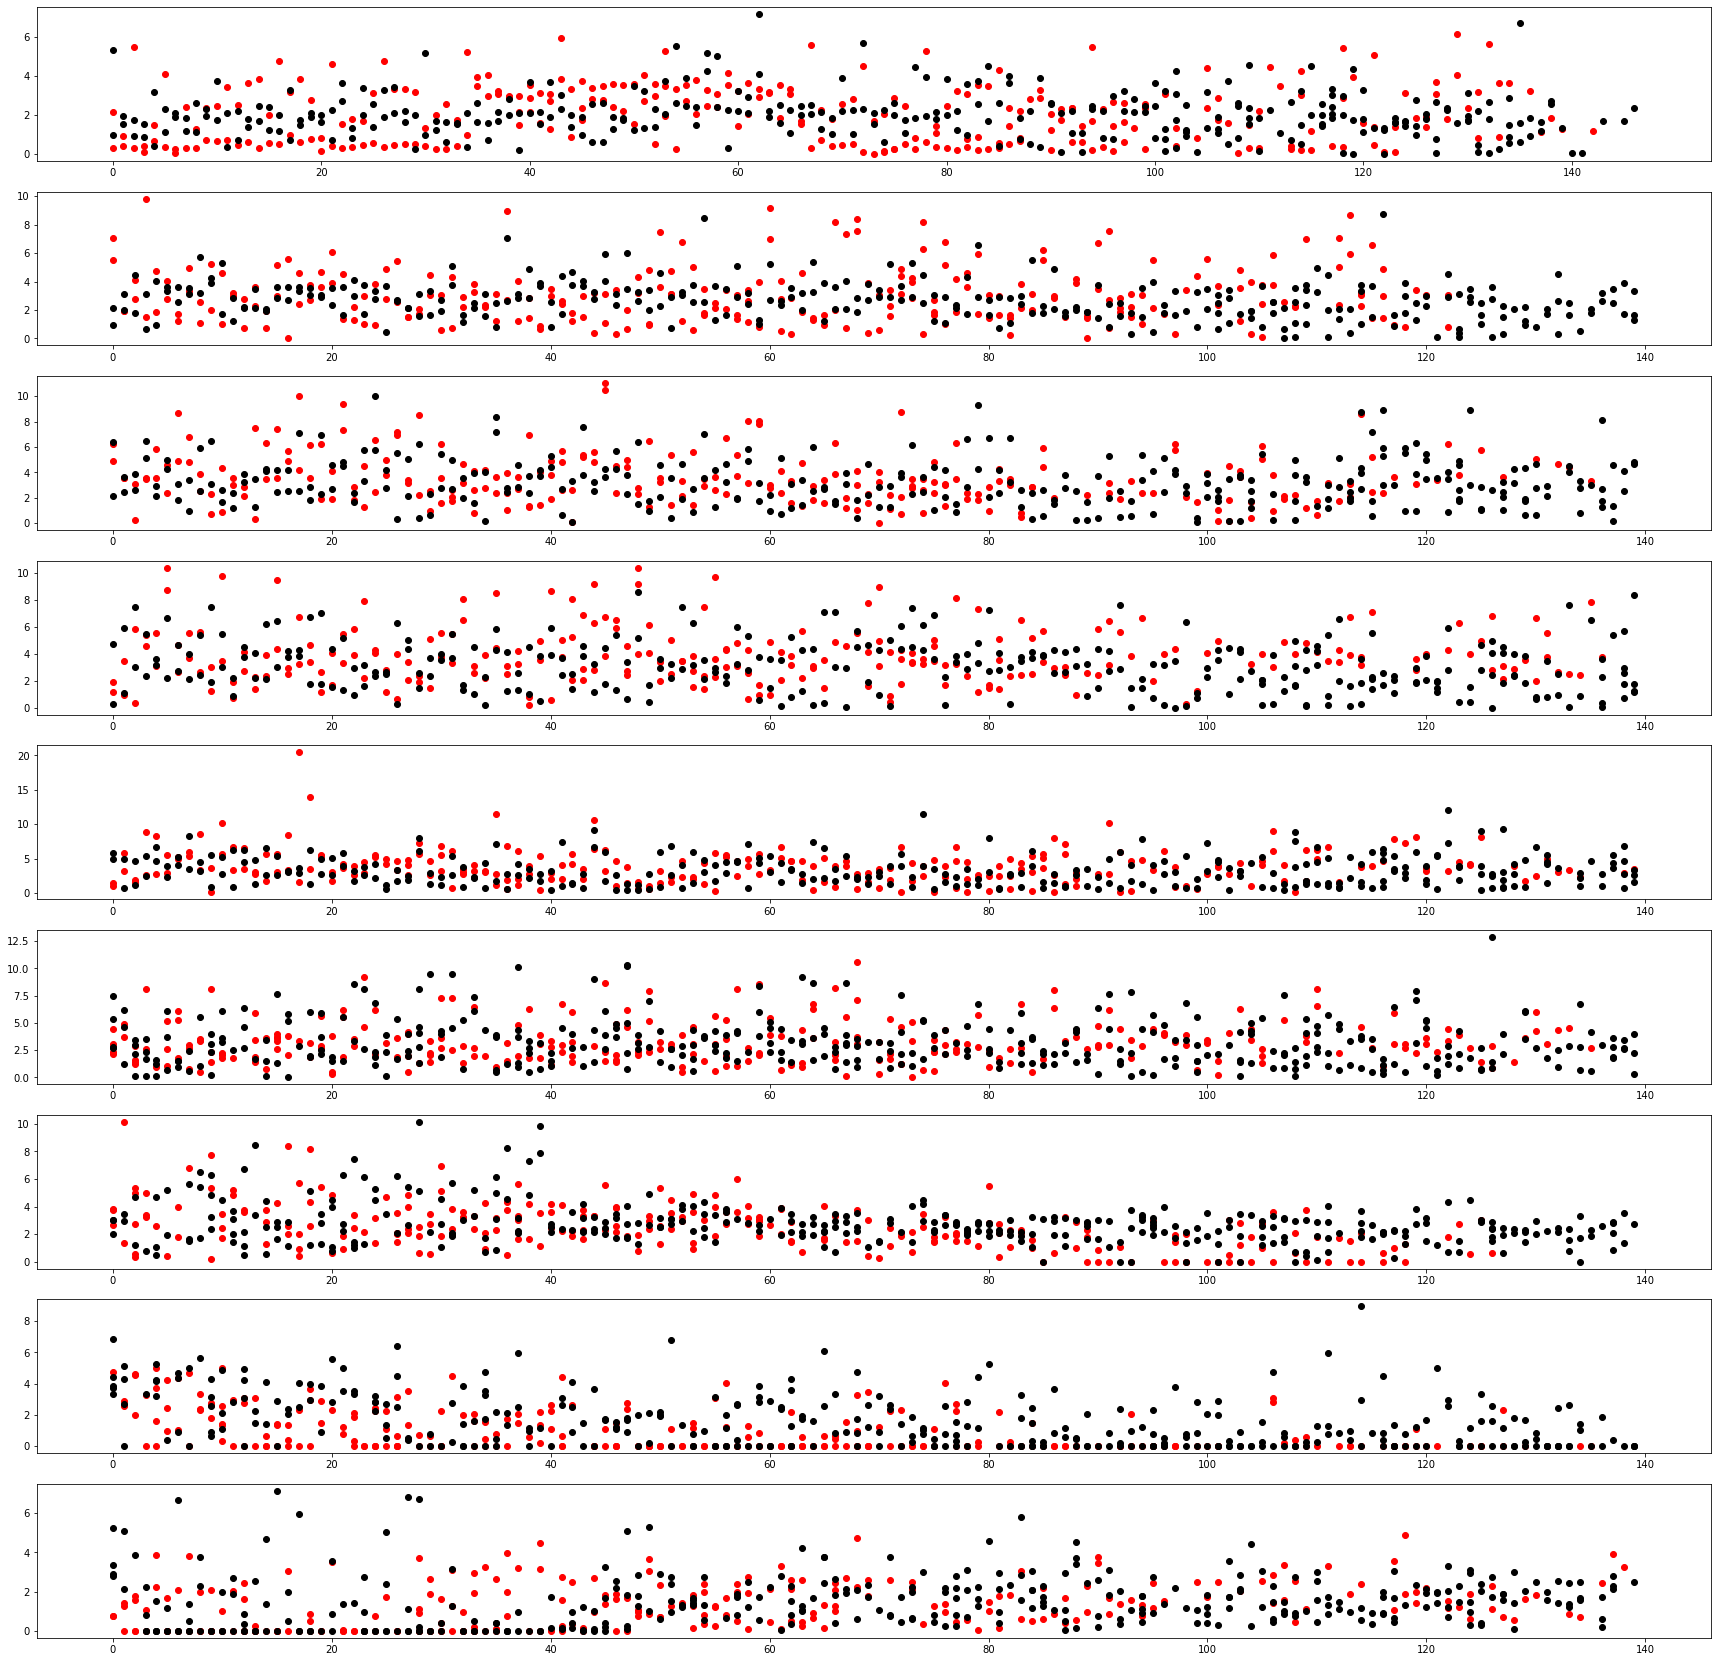

In [32]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'black')
    